In [1]:
from grizli import model
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from astropy.table import Table
from astropy import wcs
from astropy.io import fits
from glob import glob
import seaborn as sea
import os

sea.set(style='white')
sea.set(style='ticks')
sea.set_style({"xtick.direction": "in","ytick.direction": "in"})

%config InlineBackend.figure_format = 'retina'
%matplotlib inline


Couldn't `import tristars`.  Get it from https://github.com/gbrammer/tristars to enable improved blind astrometric matching with triangle asterisms.



In [2]:
def Source_present(fn,ra,dec):  ### finds source in flt file, returns if present and the pos in pixels
    flt=fits.open(fn)
    present = False
    
    w = wcs.WCS(flt[1].header)

    xpixlim=len(flt[1].data[0])
    ypixlim=len(flt[1].data)

    [pos]=w.wcs_world2pix([[ra,dec]],1)

    if -100 < pos[0] < xpixlim and 0 < pos[1] < ypixlim and flt[0].header['OBSTYPE'] == 'SPECTROSCOPIC':
        present=True
            
    return present,pos

In [4]:
mosaic = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits'
seg_map = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F160W_seg.fits'
catalog = '/Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.3.cat'
instrument = 'G102' # or G141
galaxy_id = 21156

ref_cat = Table.read(catalog ,format='ascii')
galaxy_ra = float(ref_cat['ra'][ref_cat['id'] == galaxy_id])
galaxy_dec = float(ref_cat['dec'][ref_cat['id'] == galaxy_id])

In [5]:
flt_files = glob('/Users/vestrada/Clear_data/n_flt_files/*')

In [6]:
goodflts = []
for i in flt_files:
    in_flt,loc = Source_present(i,galaxy_ra,galaxy_dec)
    if in_flt:
        goodflts.append(i)

In [7]:
def Extract_spec(target_id, grism_file, mosaic, seg_map, instruement, catalog):
    flt = model.GrismFLT(grism_file = grism_file ,
                          ref_file = mosaic, seg_file = seg_map,
                            pad=200, ref_ext=0, shrink_segimage=True, force_grism = instrument)
    
    # catalog / semetation image
    ref_cat = Table.read(catalog ,format='ascii')
    seg_cat = flt.blot_catalog(ref_cat,sextractor=False)
    flt.compute_full_model(ids=seg_cat['id'])
    beam = flt.object_dispersers[target_id][2]['A']
    co = model.BeamCutout(flt, beam, conf=flt.conf)
    
    xspec, yspec, yerr = co.beam.optimal_extract(co.grism.data['SCI'], bin=0, ivar=co.ivar) #data
    
    flat = co.flat_flam.reshape(co.beam.sh_beam)
    fwv, ffl, e = co.beam.optimal_extract(flat, bin=0)

#     ### add EXPTIME to extension 0   
#     plt.figure(figsize=[15,8])
#     plt.errorbar(xspec, yspec/ffl, yerr/ffl,linestyle='None', marker='o', markersize=3)
    return xspec, yspec/ffl, yerr/ffl

In [8]:
for i in range(len(goodflts)):
    wv,fl,er = Extract_spec(21156, goodflts[i], mosaic, seg_map, instrument,catalog)
    np.save('specs/stack_{0}'.format(i),[wv,fl,er])

/Users/vestrada/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.7.0-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:1470: RuntimeWarning: invalid value encountered in less
  bad = self.data['SCI'] < sigma*self.data['ERR']


Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot reference /Users/vestrada/Clear_data/goodsn_mosaic/goodsn_3dhst.v4.0.F125W_orig_sci.fits[0]
The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol
Using default C-based coordinate transformation...
Image cutout: x=slice(7787, 13144, None), y=slice(8991, 14205, None)
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / Pad ref HDU with 50 pixels
/Users/vestrada/Clear_data/n_flt_files/icat21cfq_flt.fits / blot segme

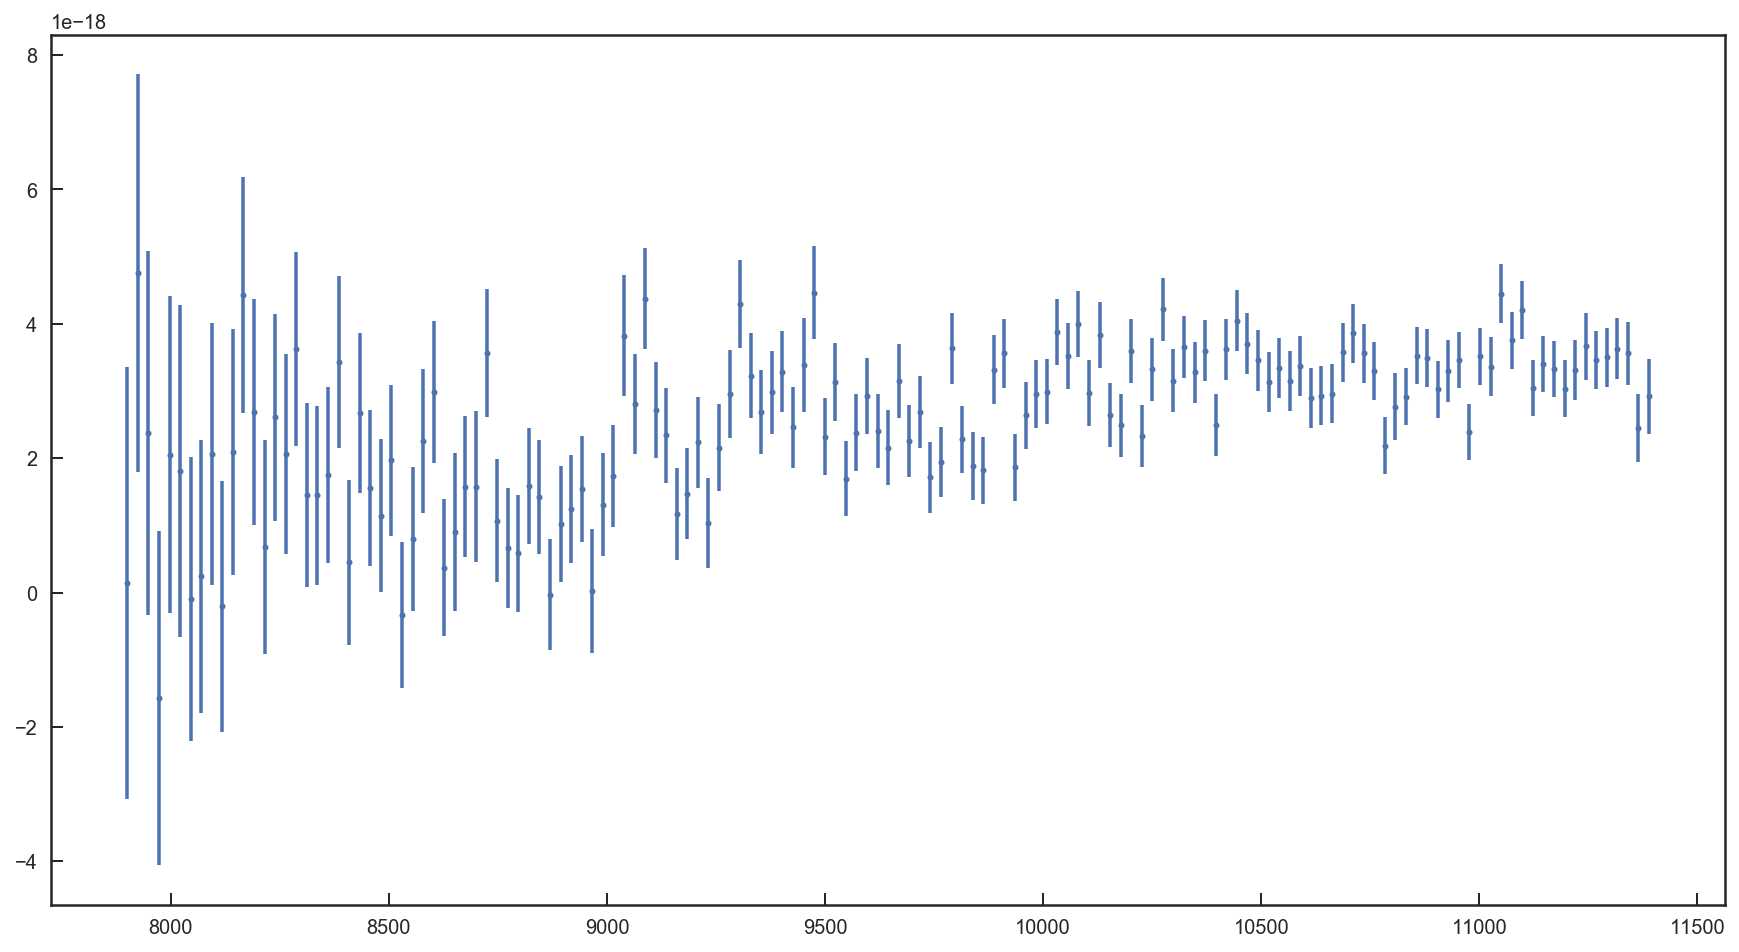

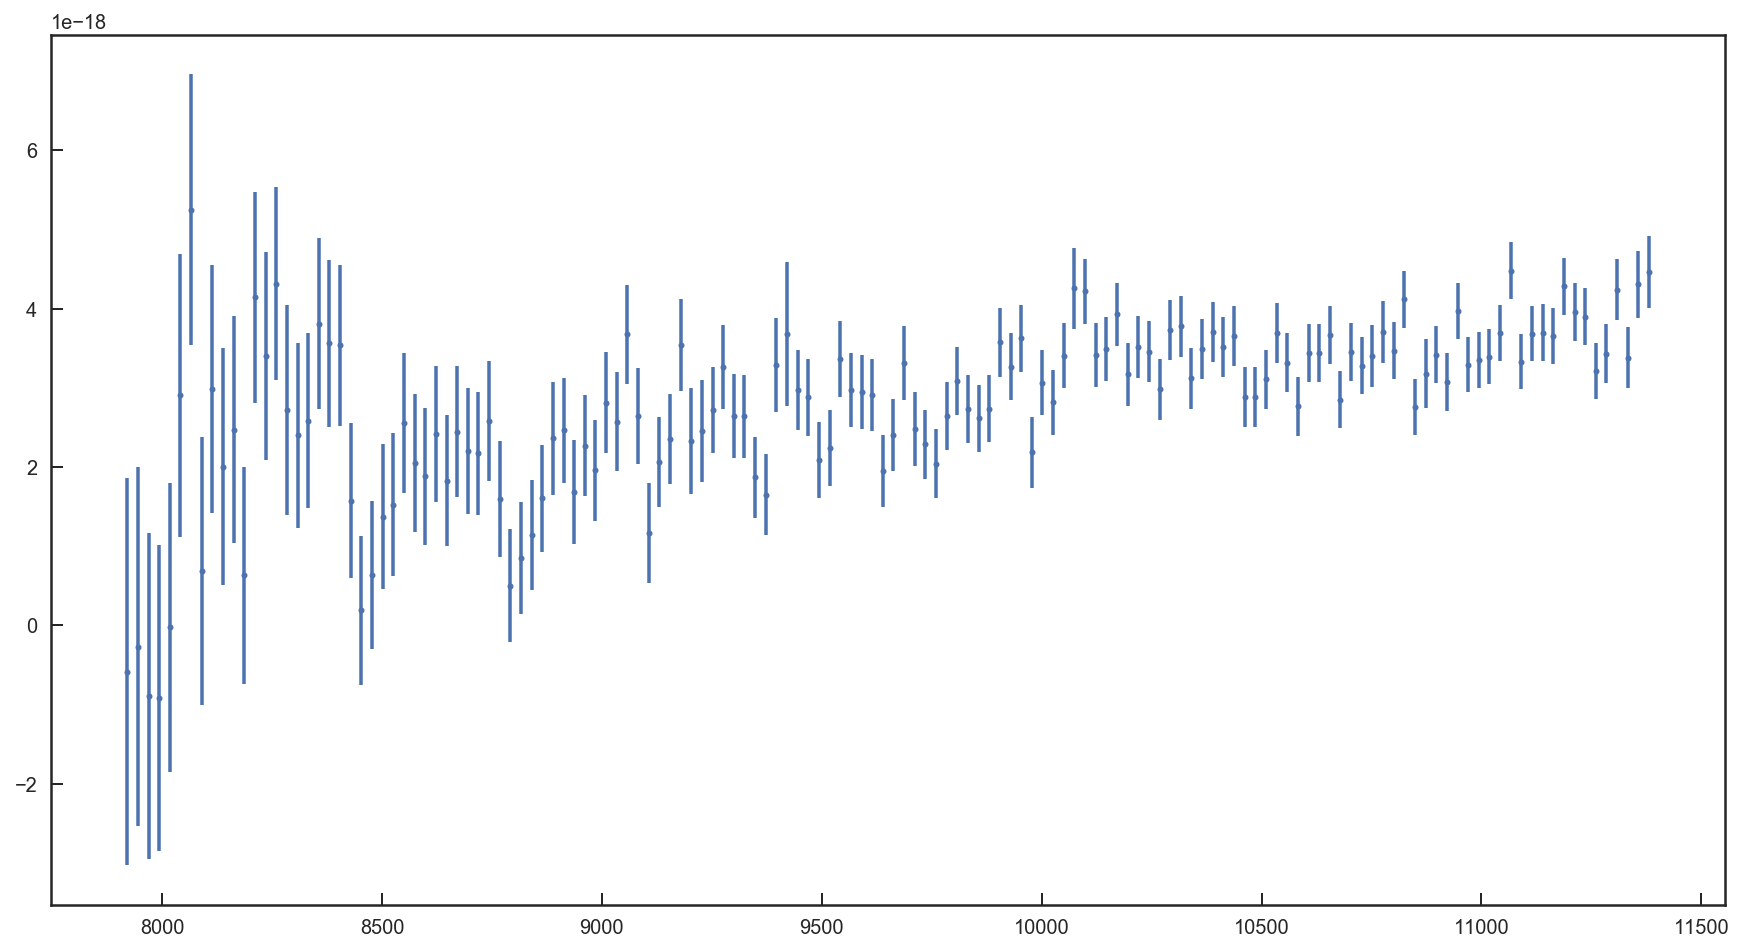

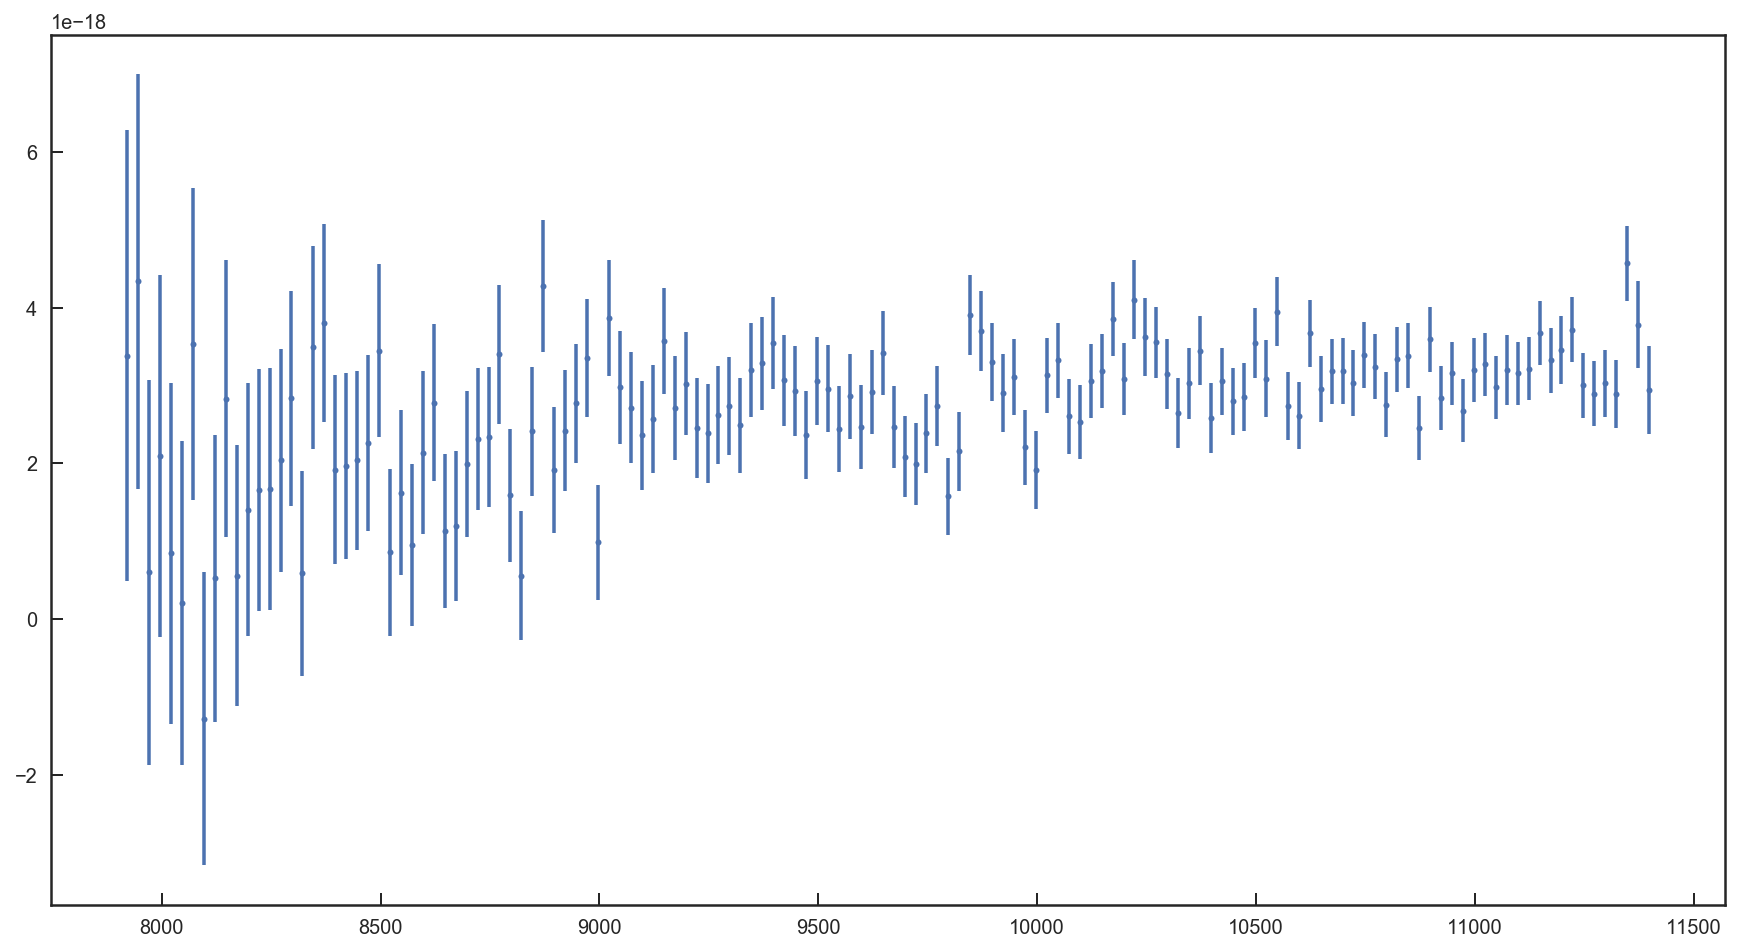

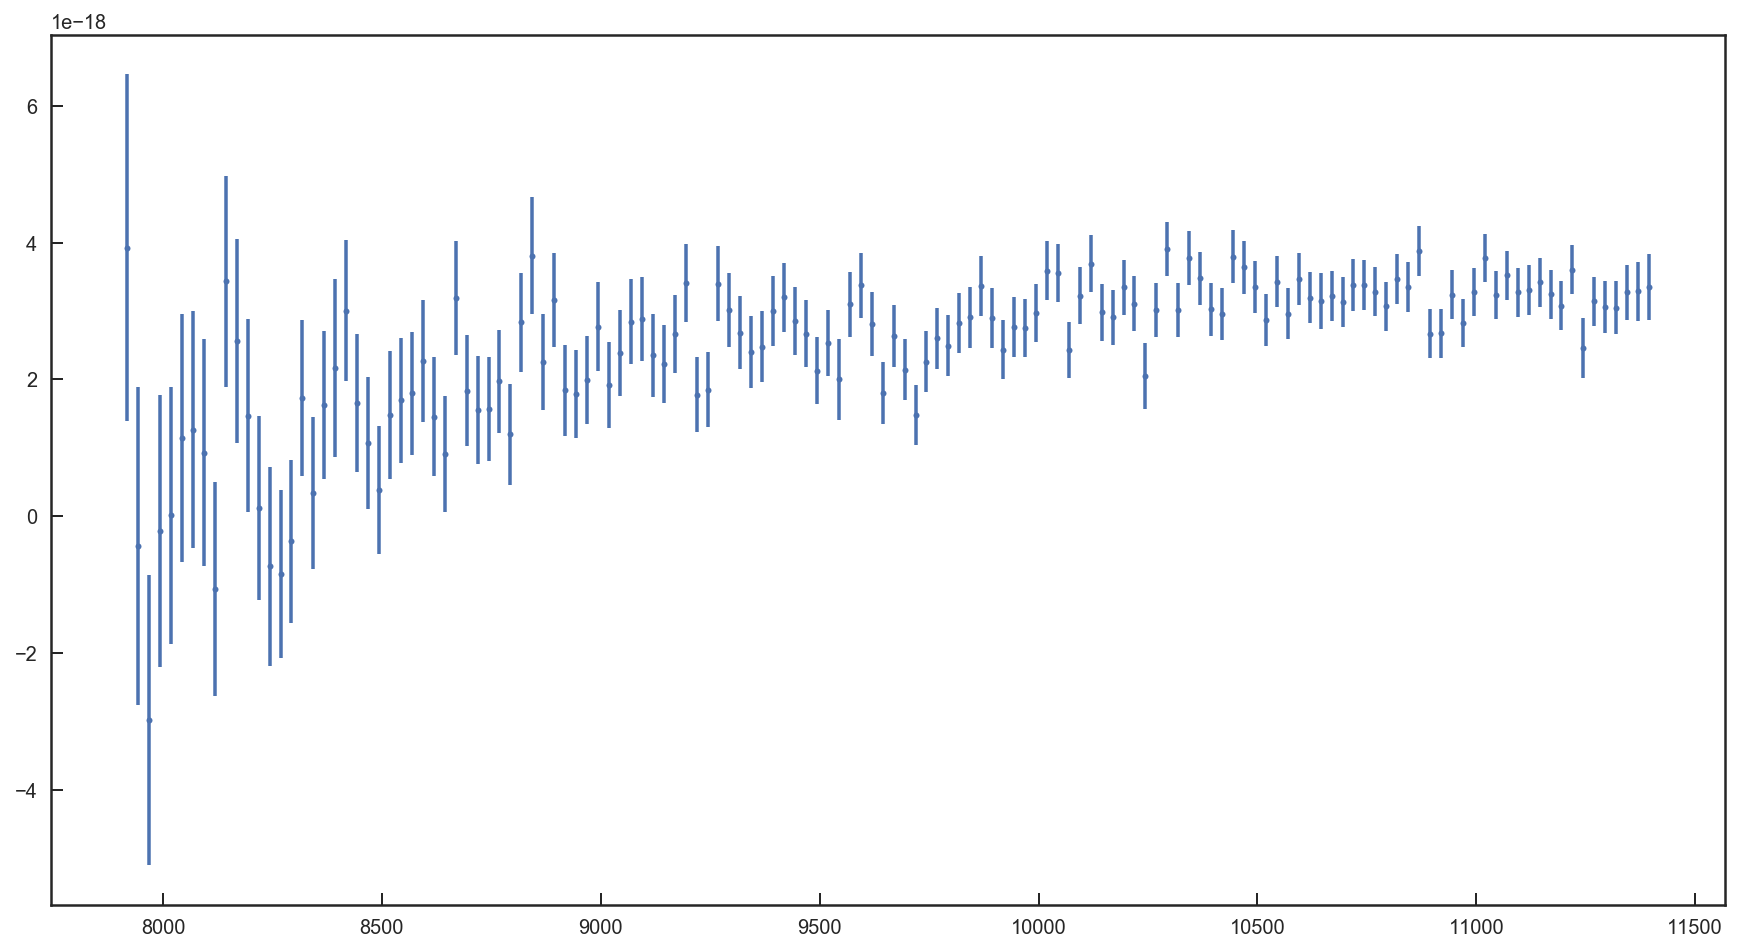

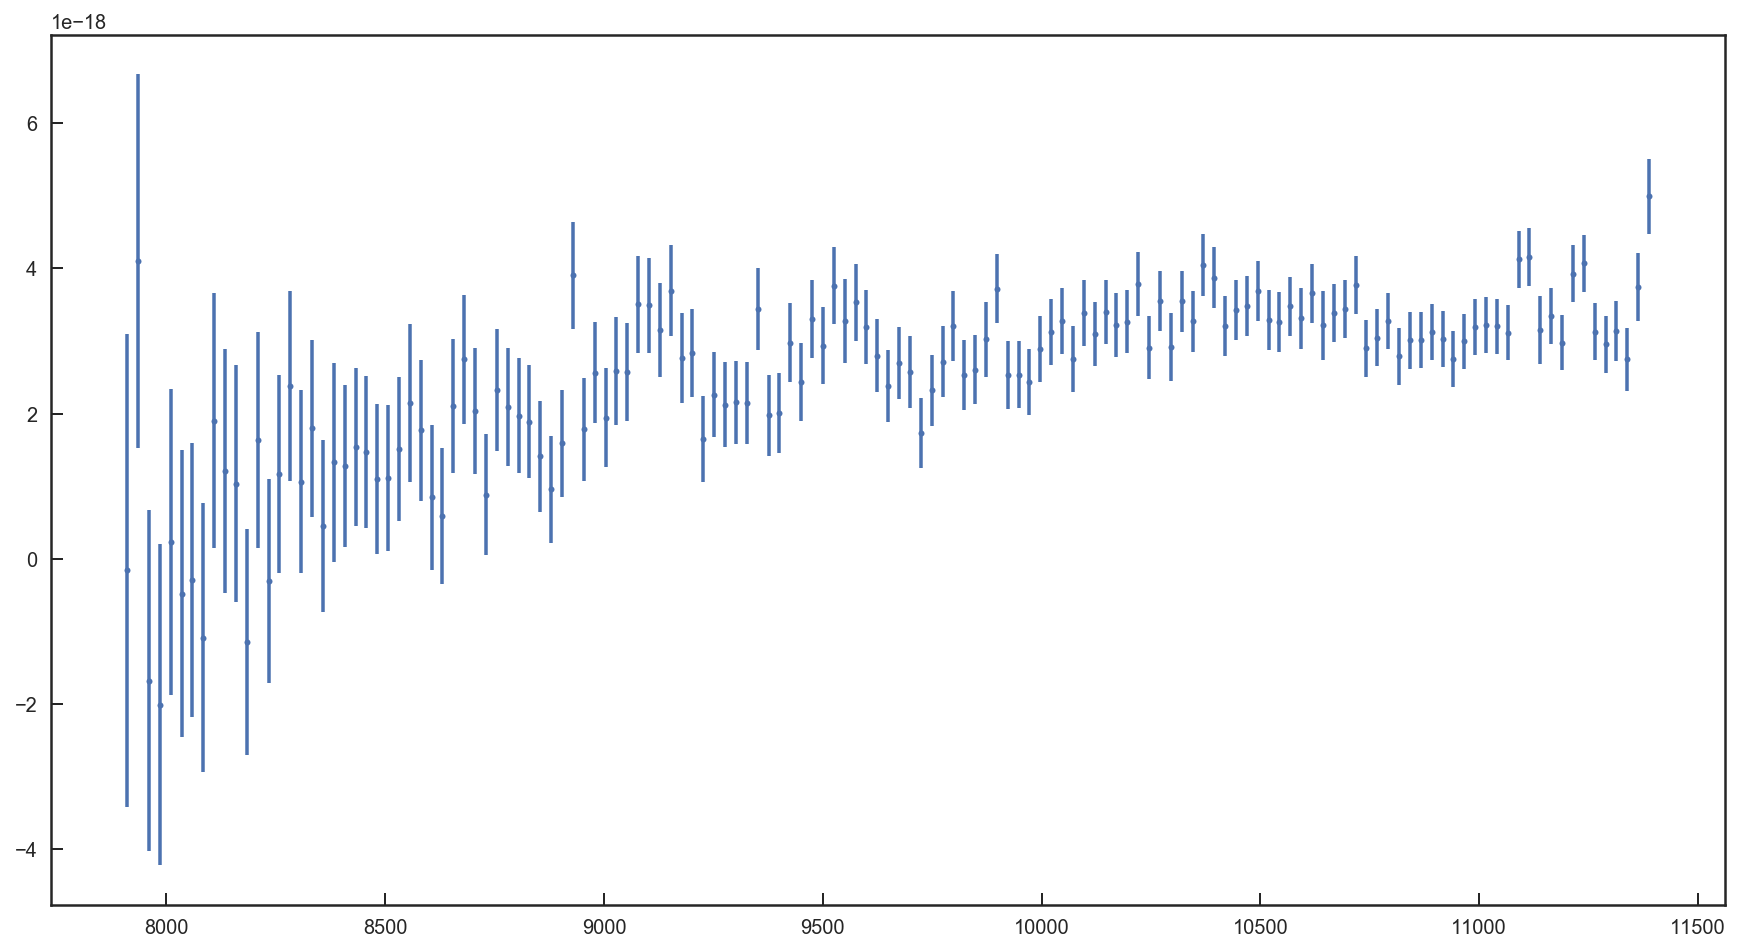

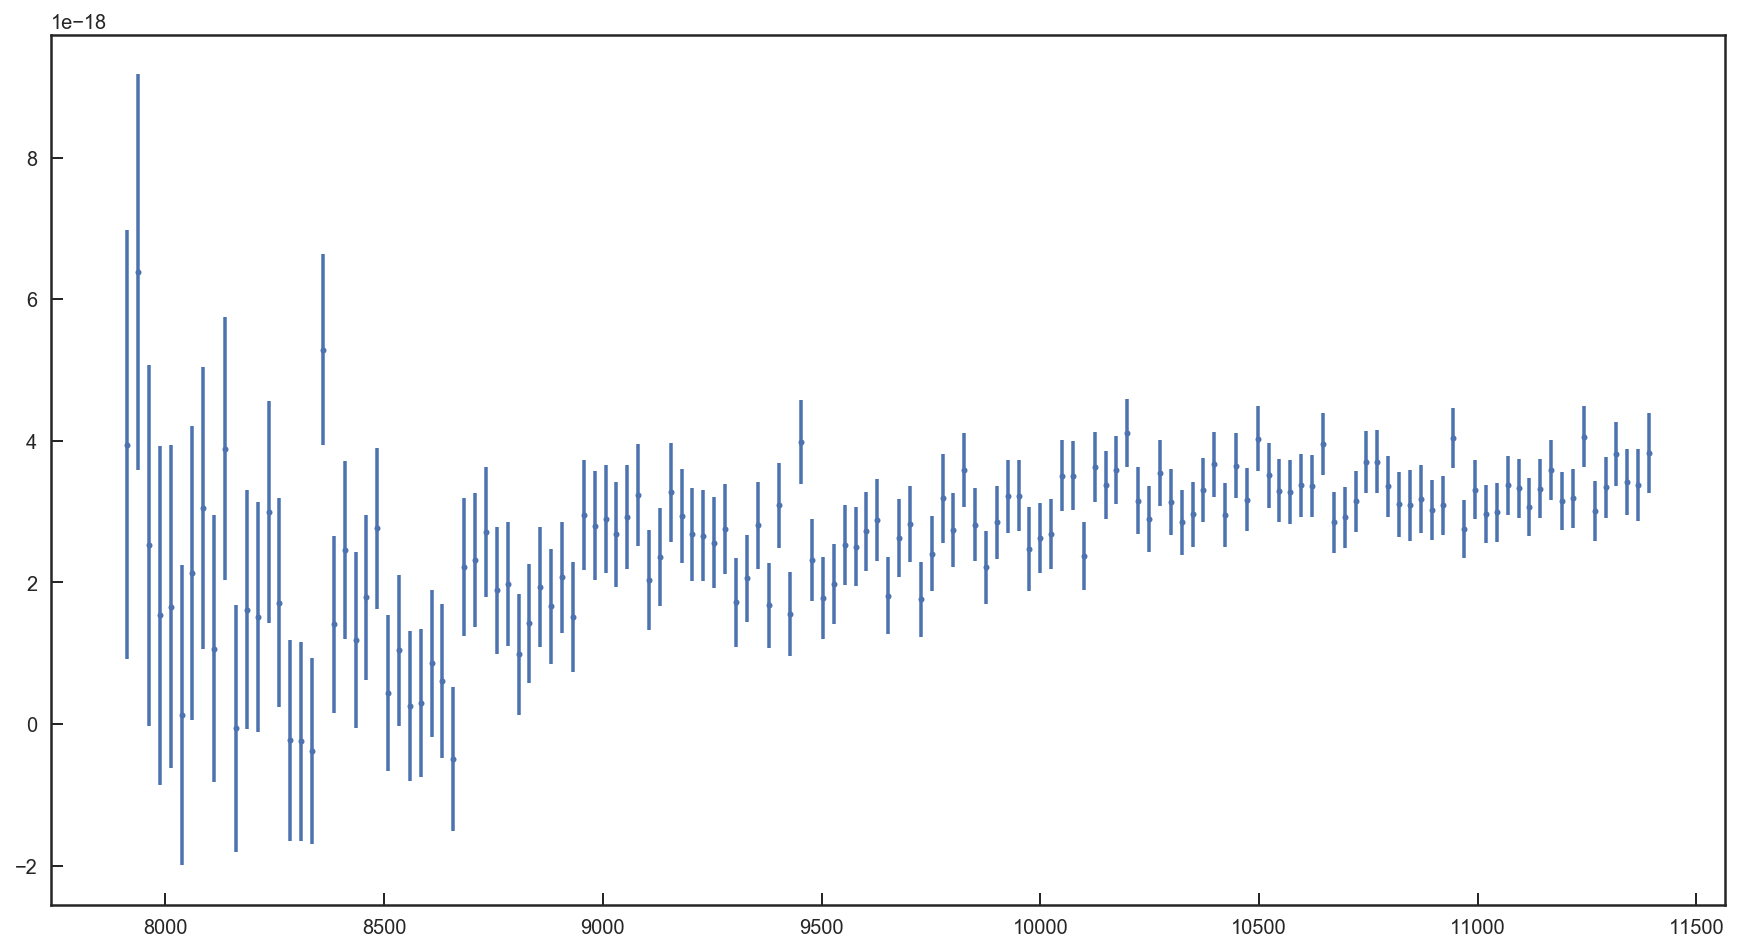

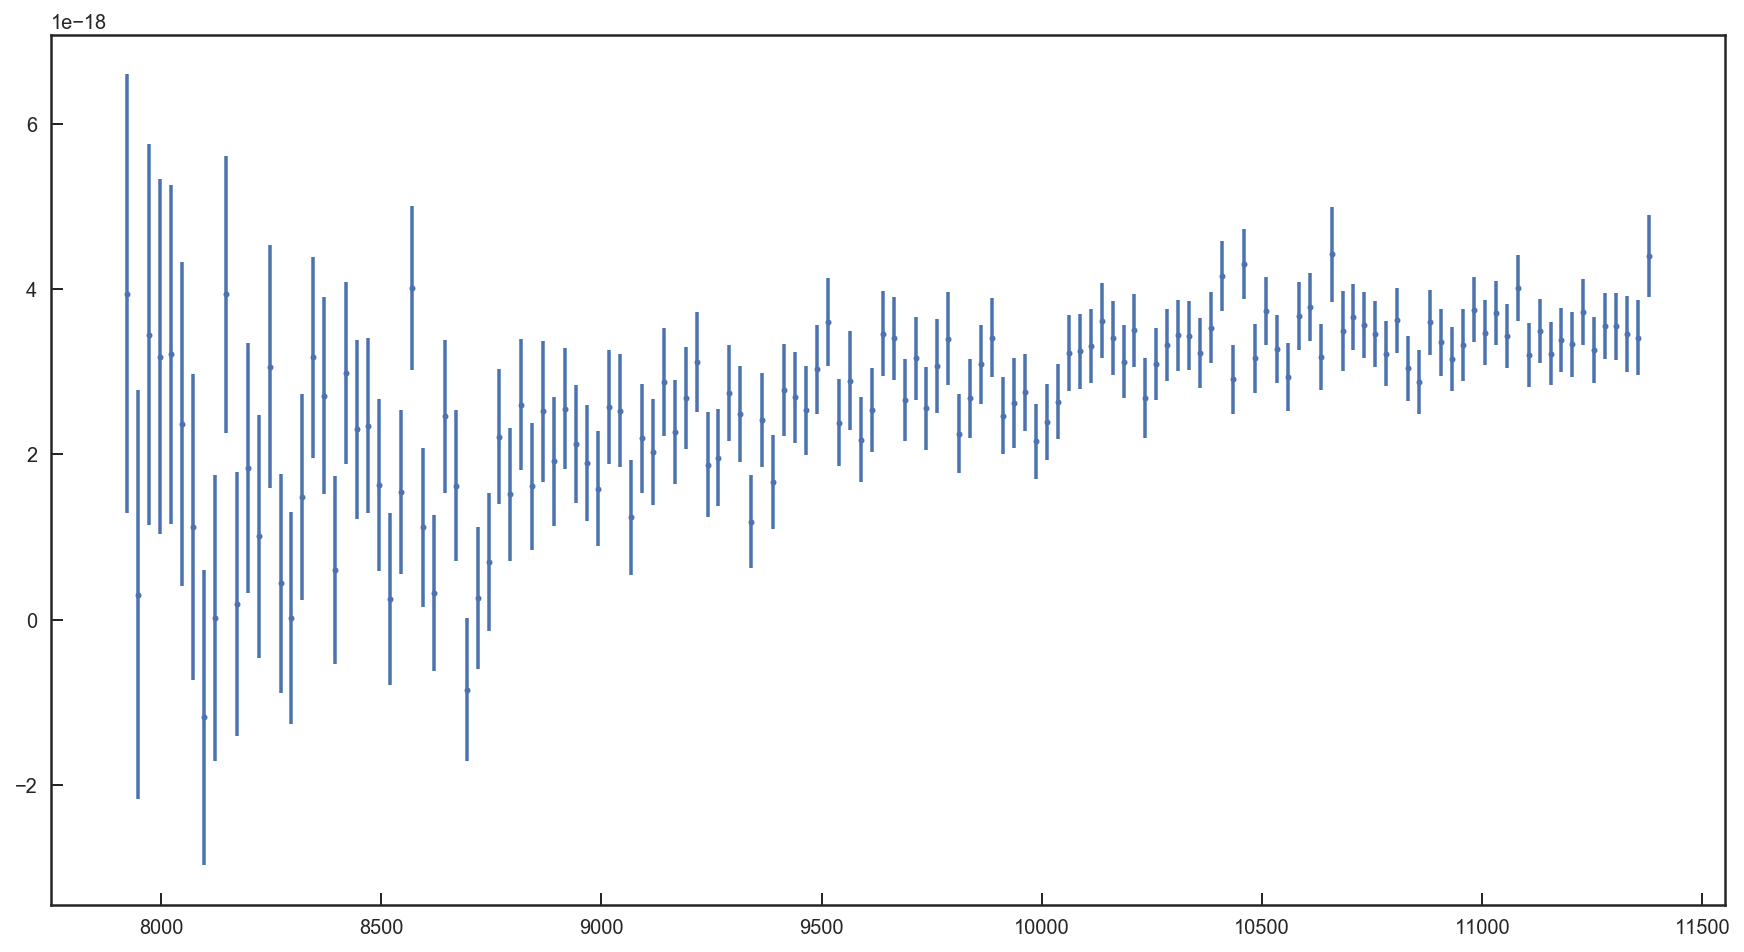

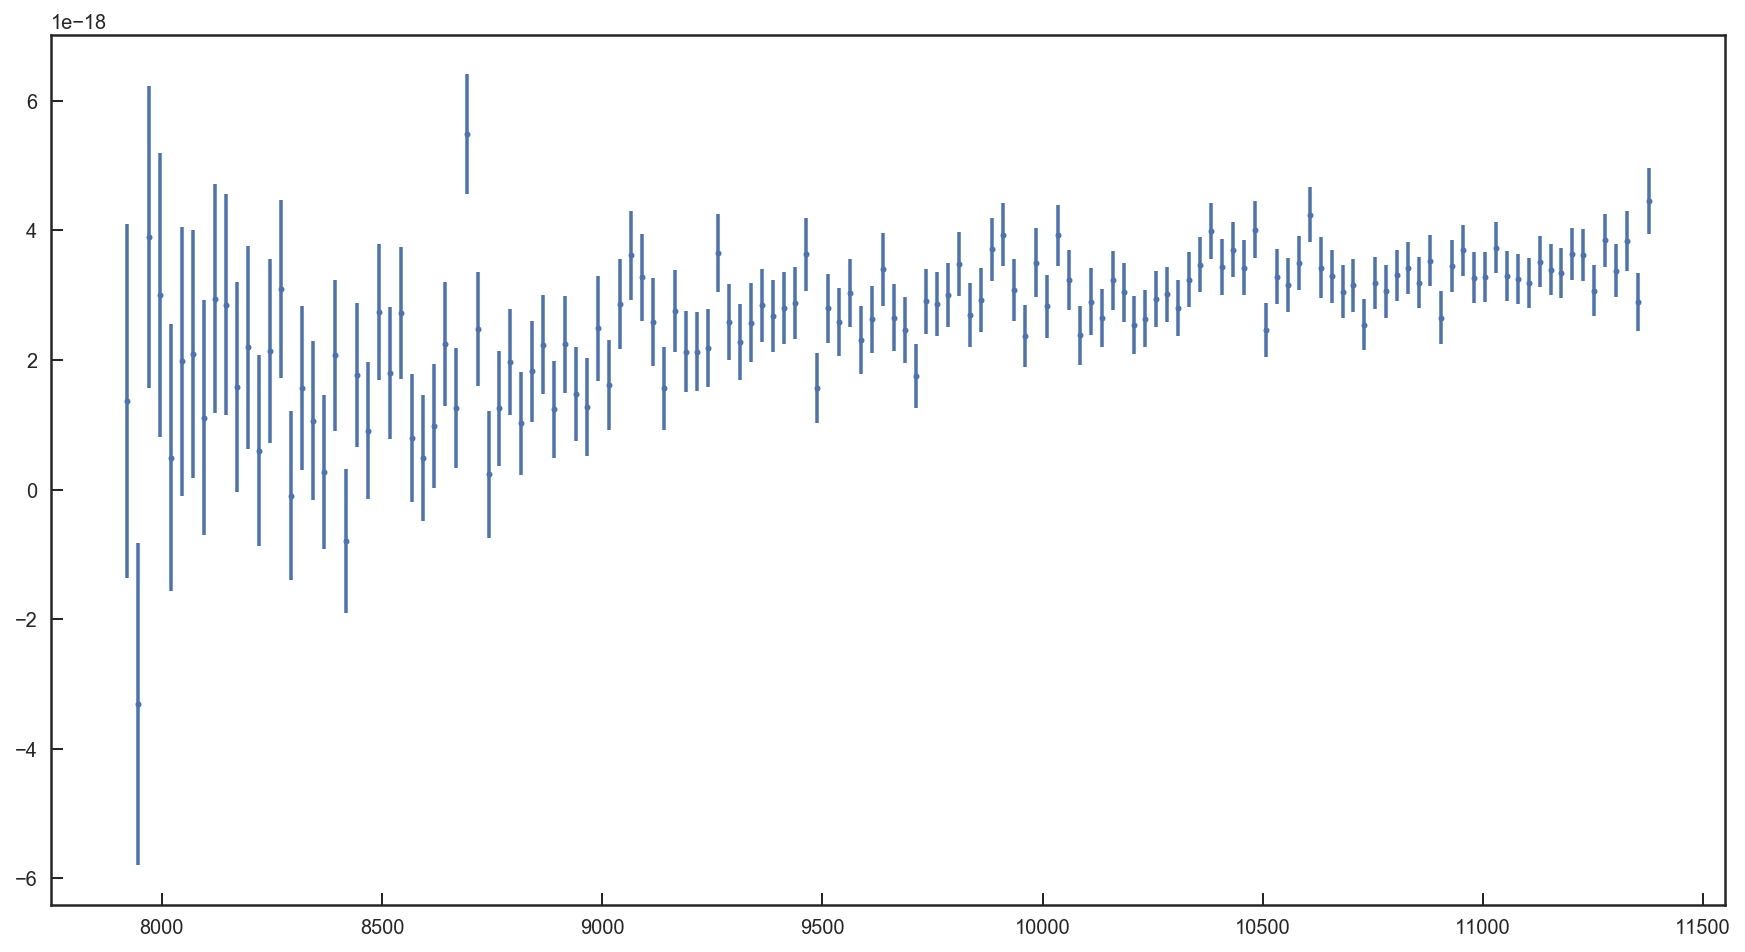

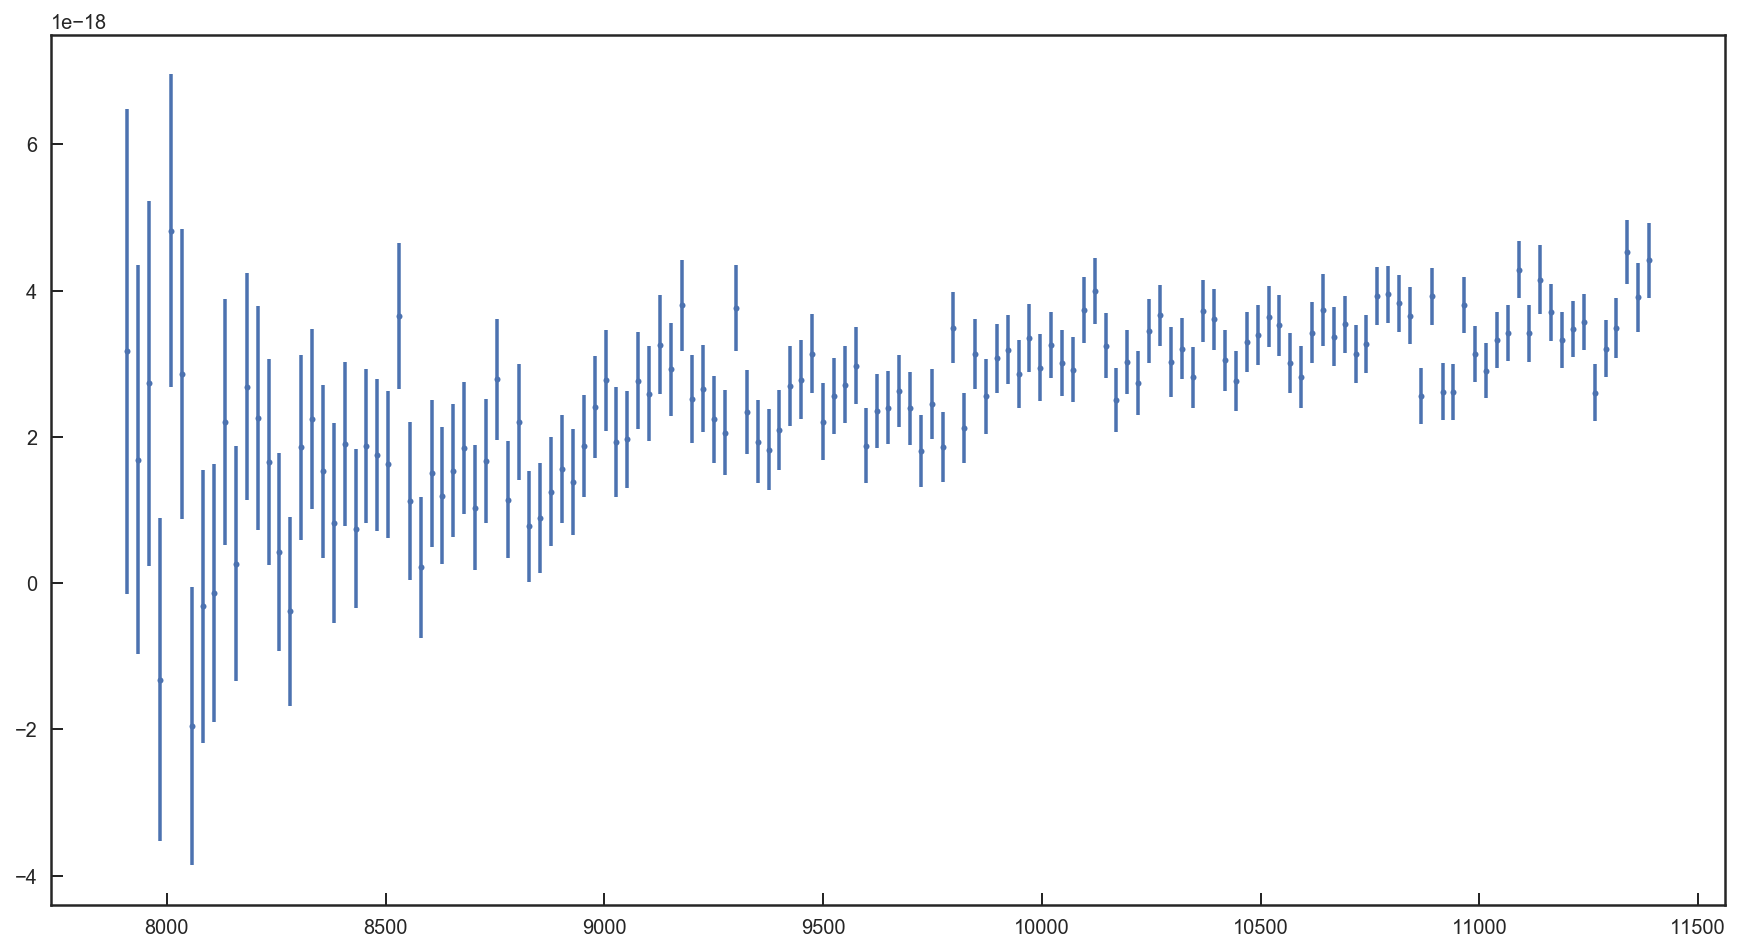

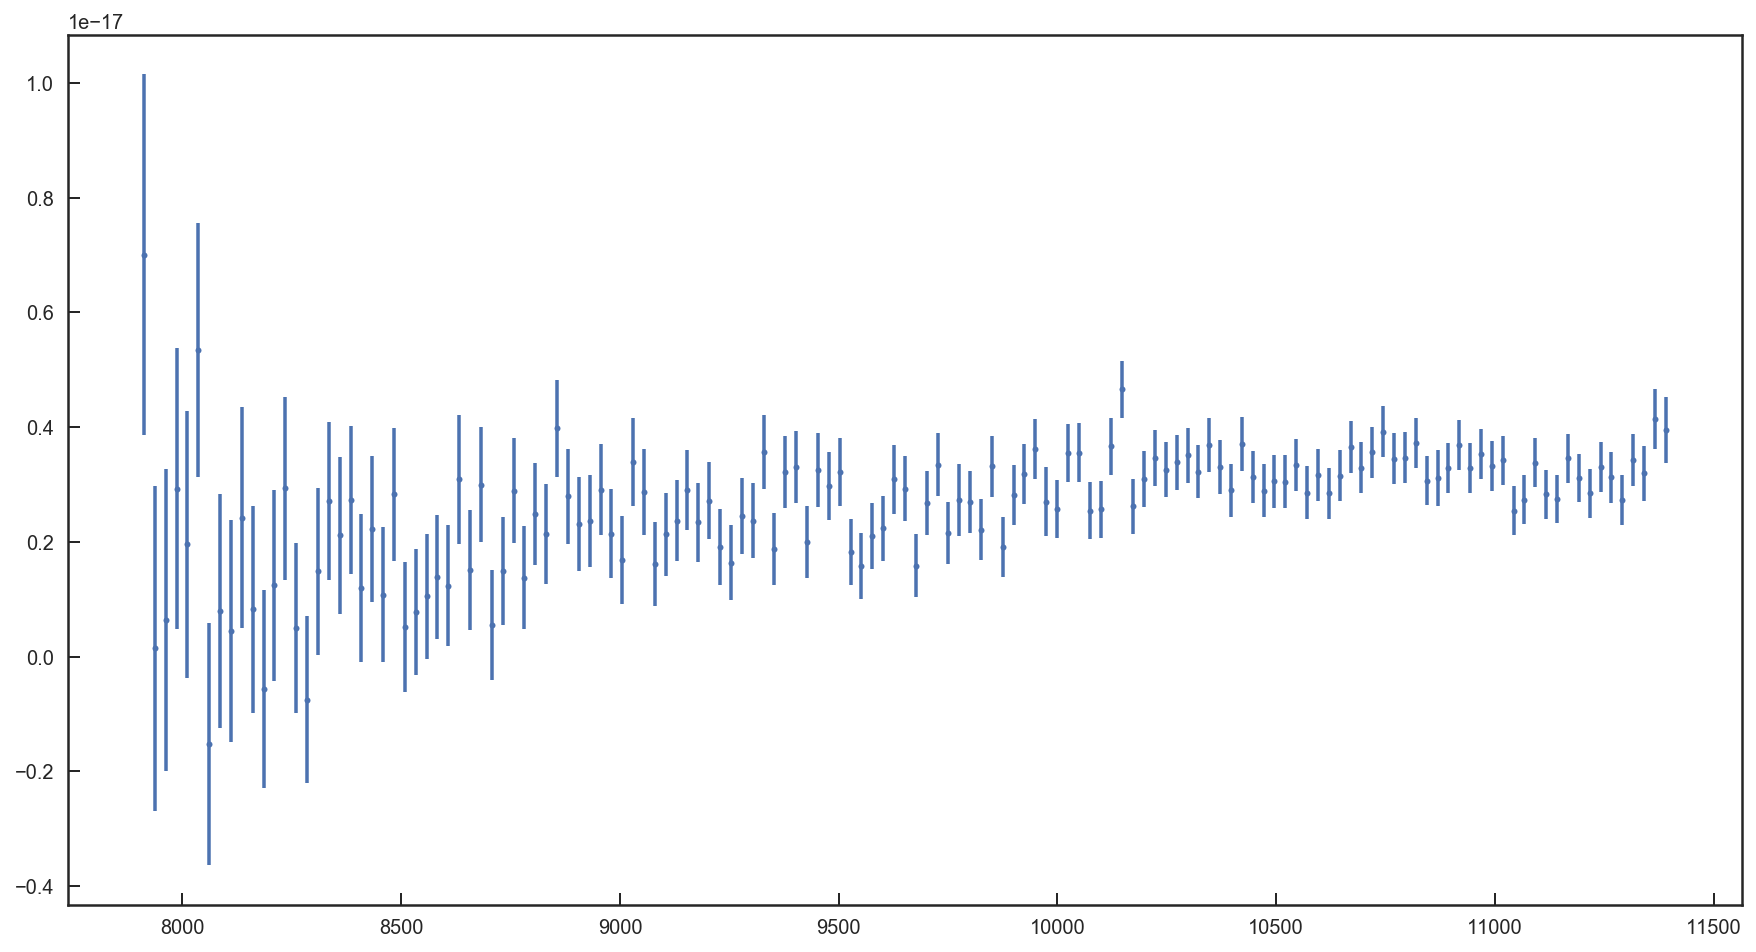

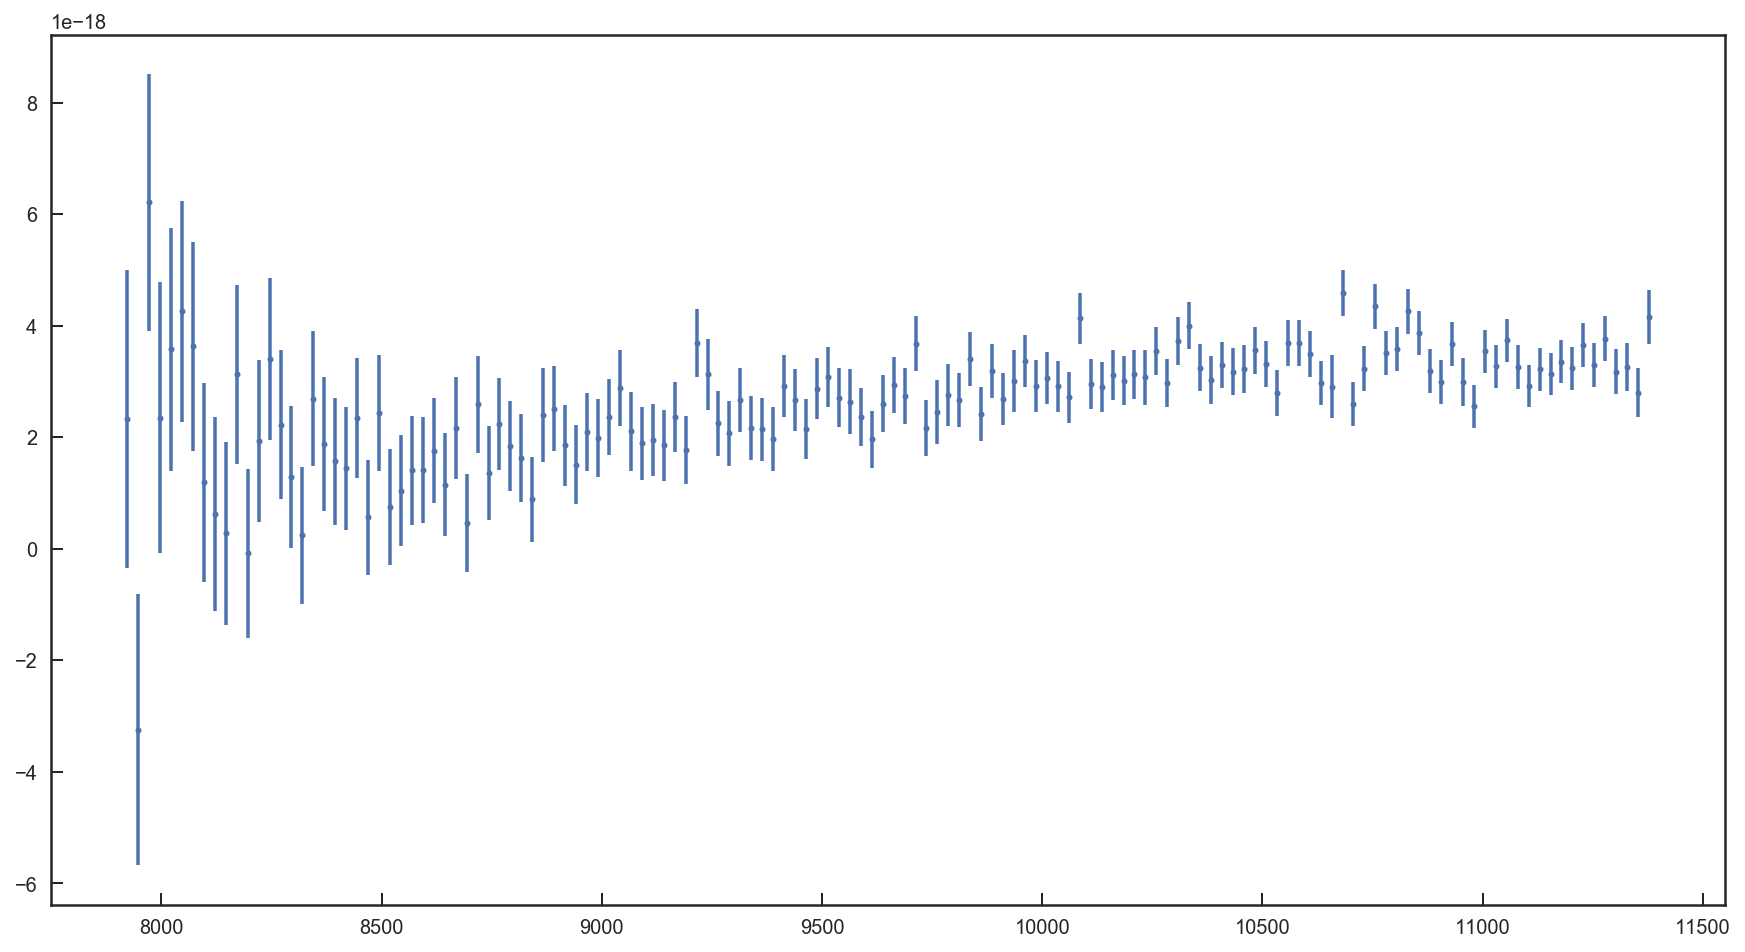

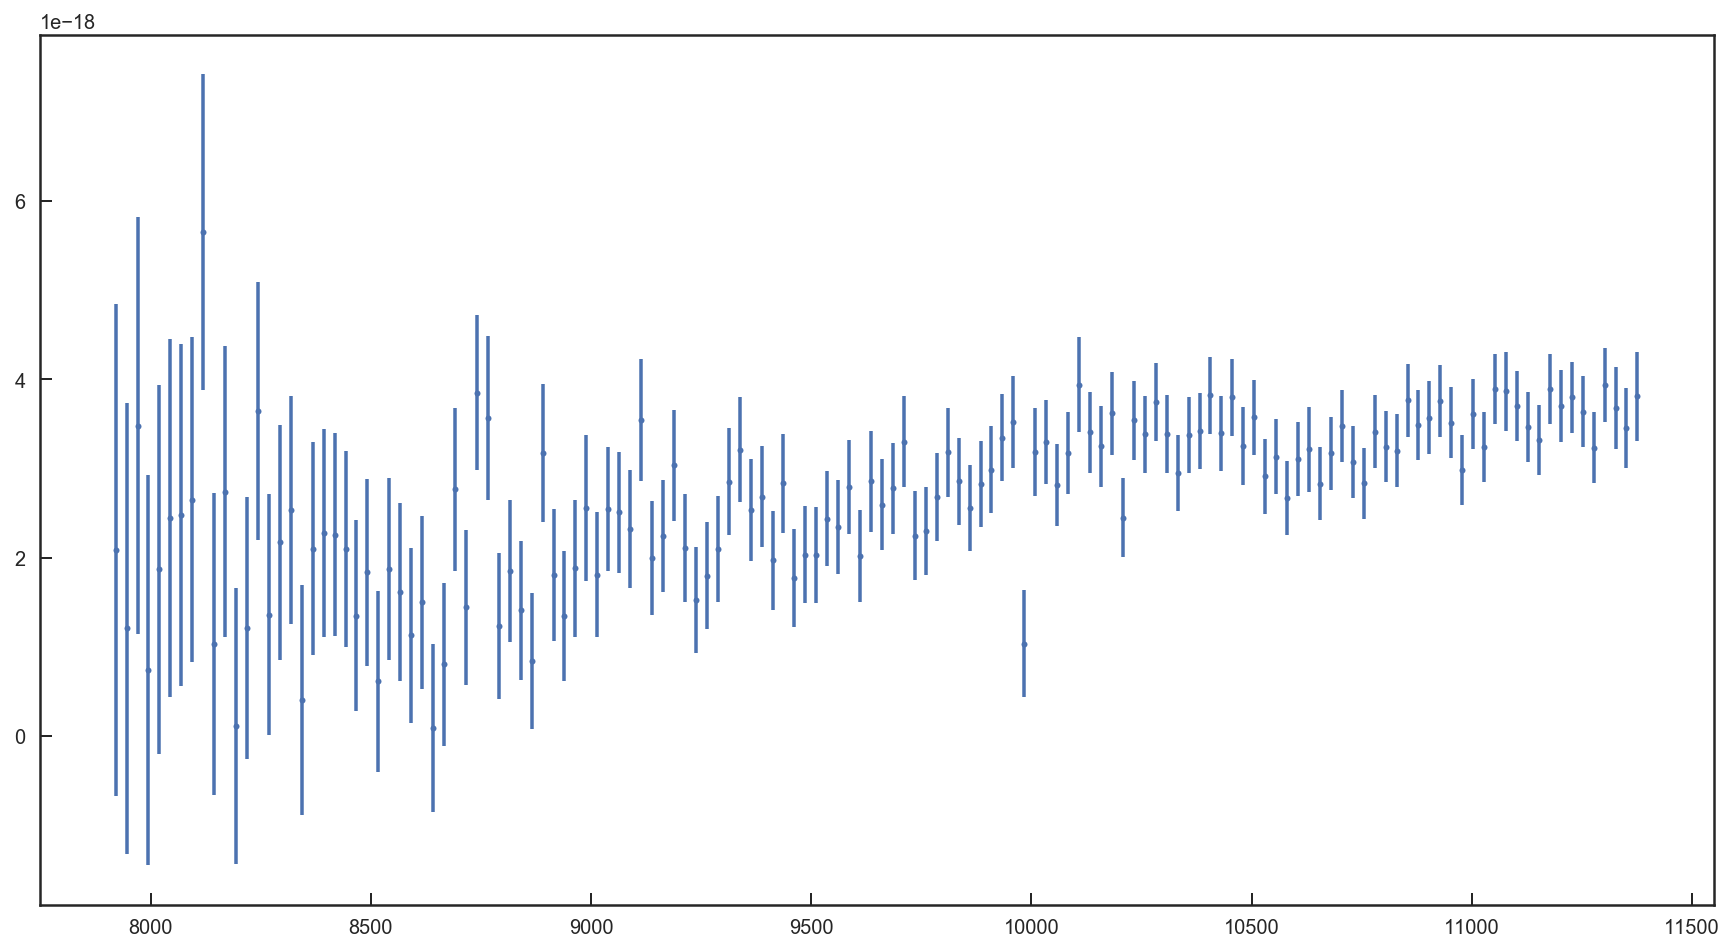

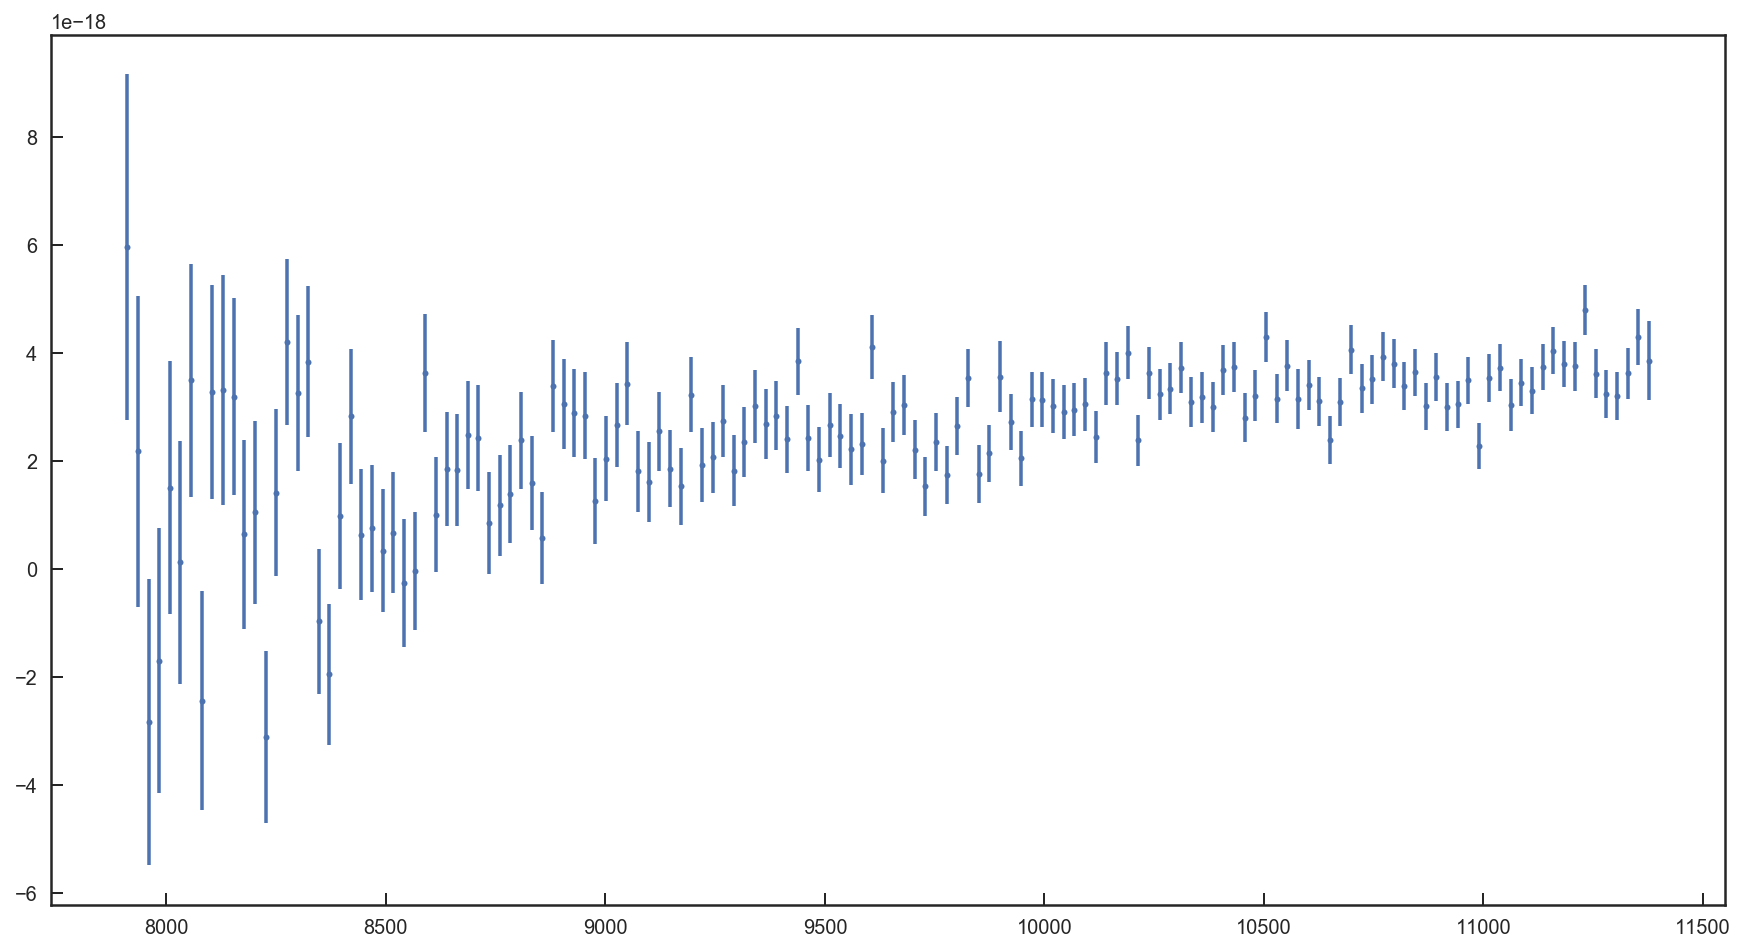

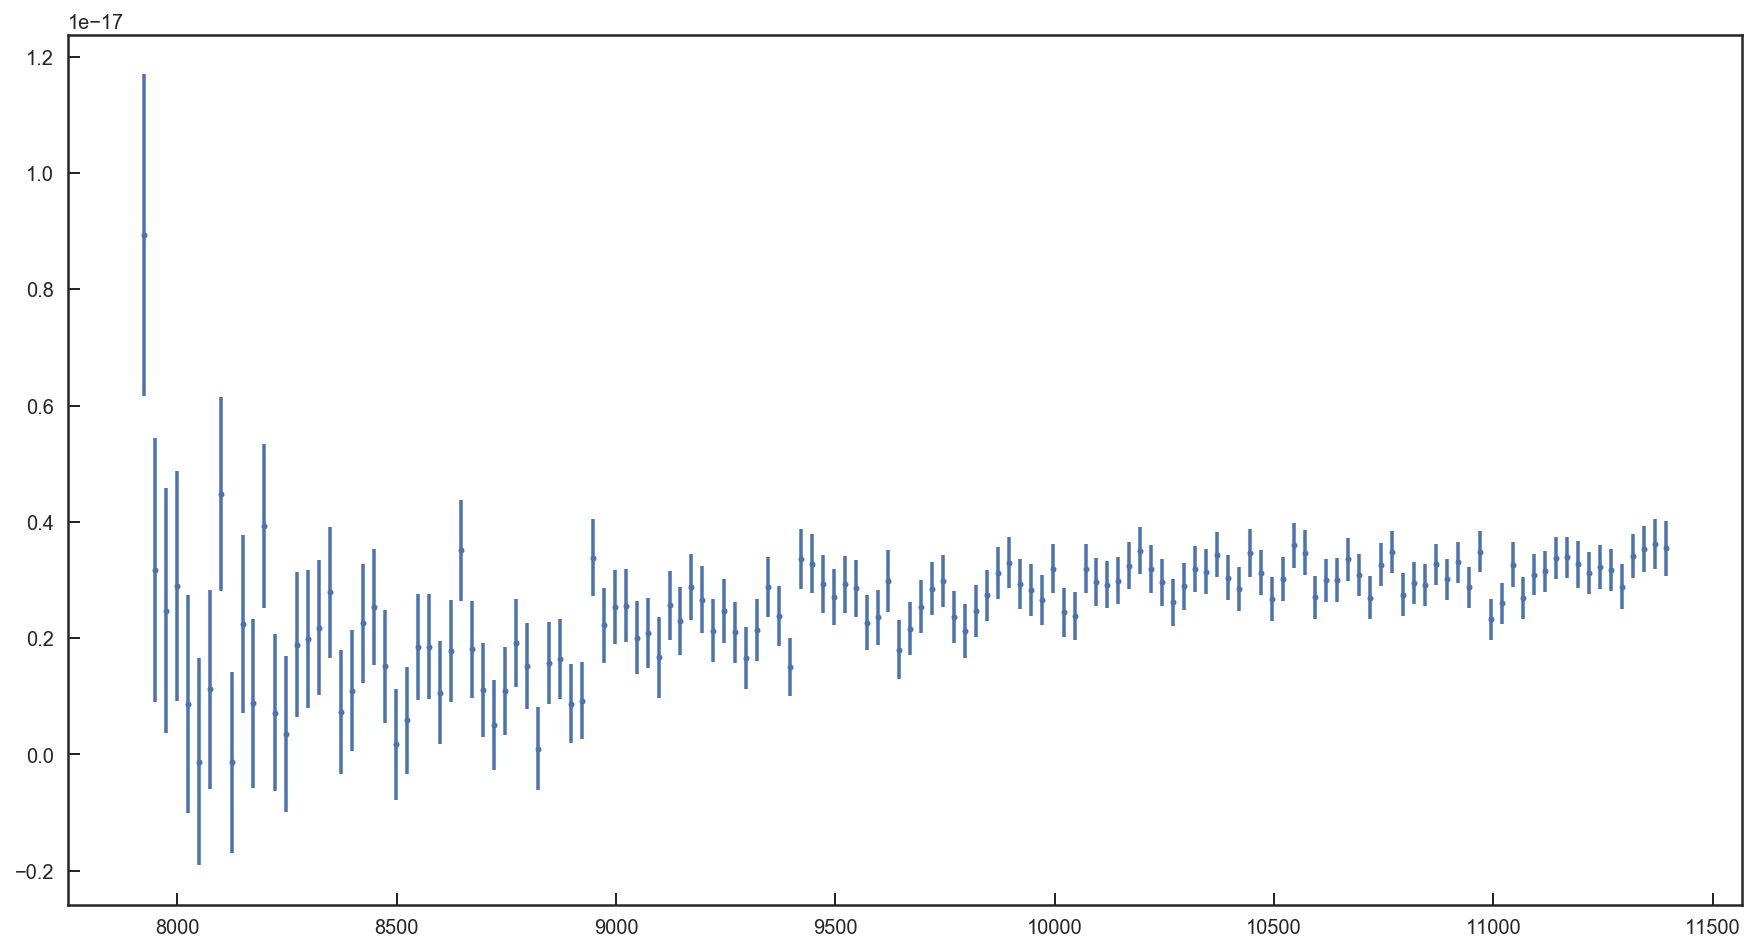

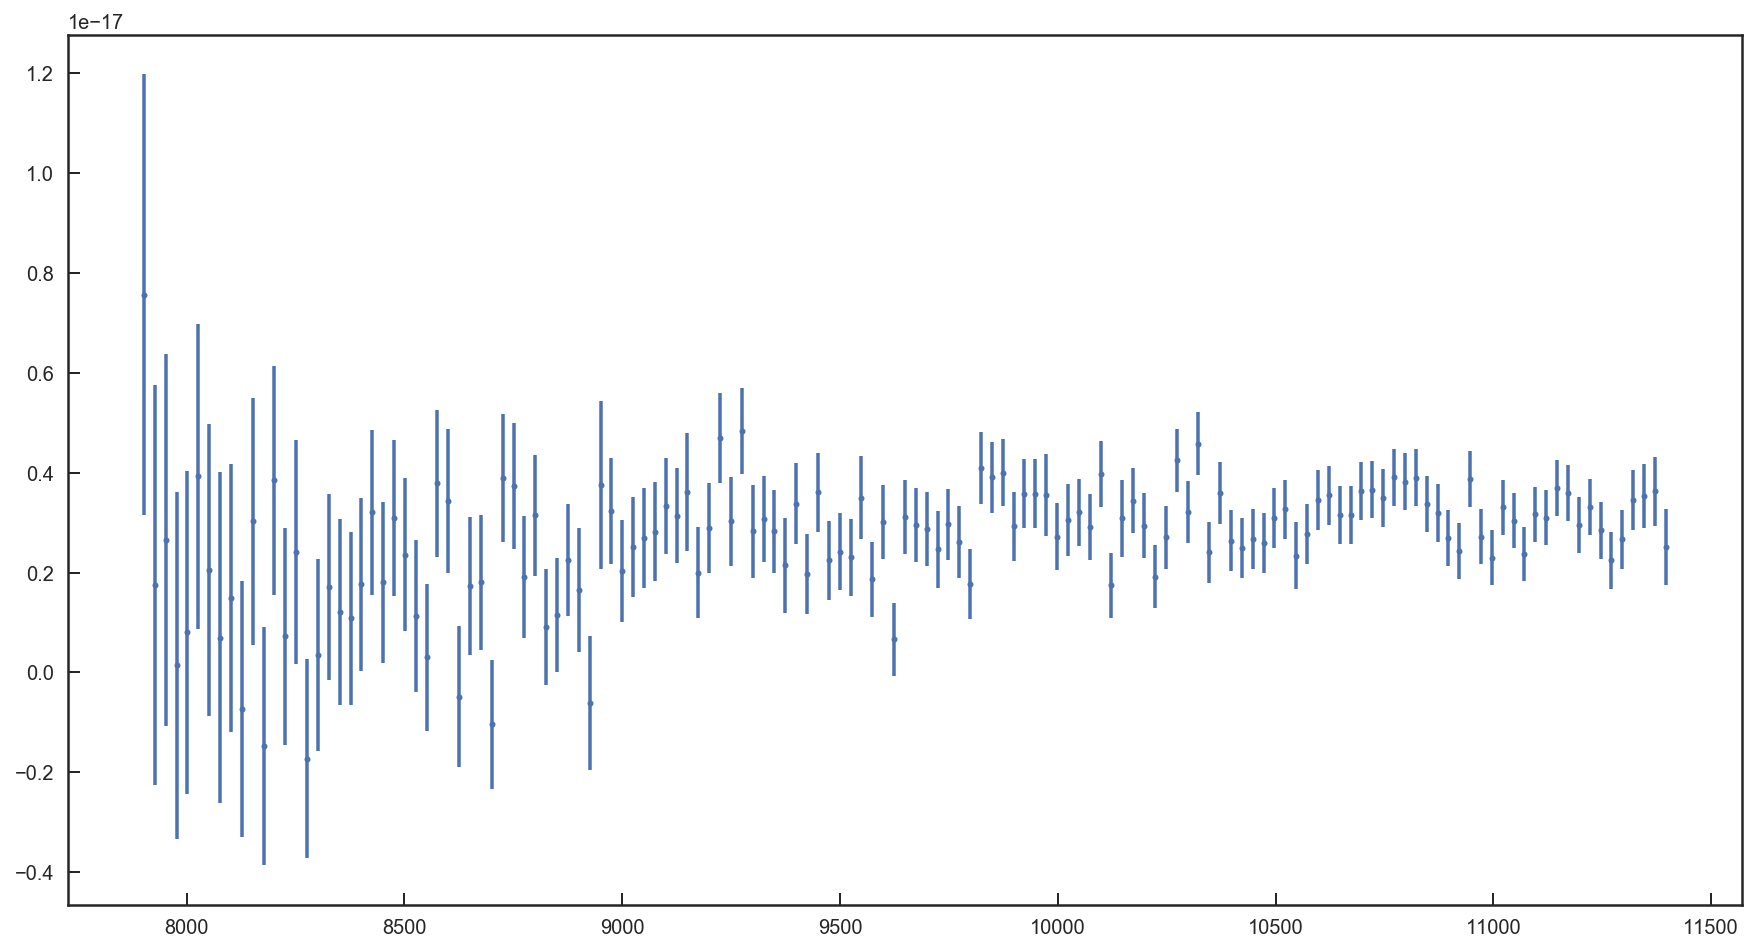

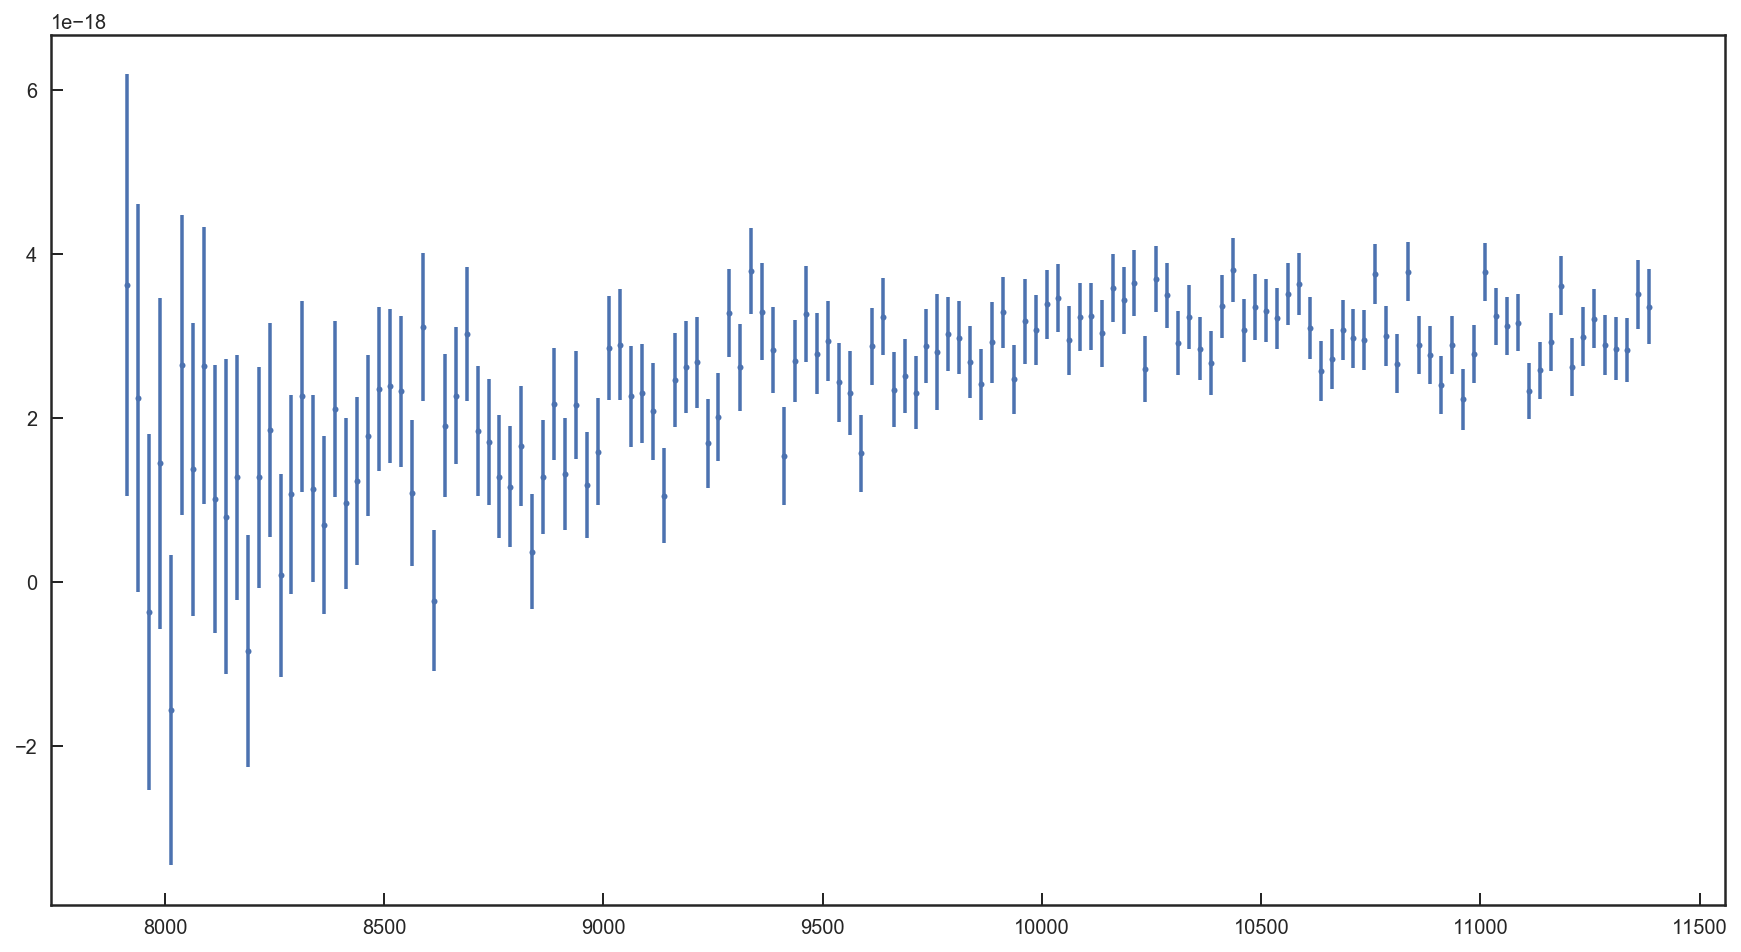

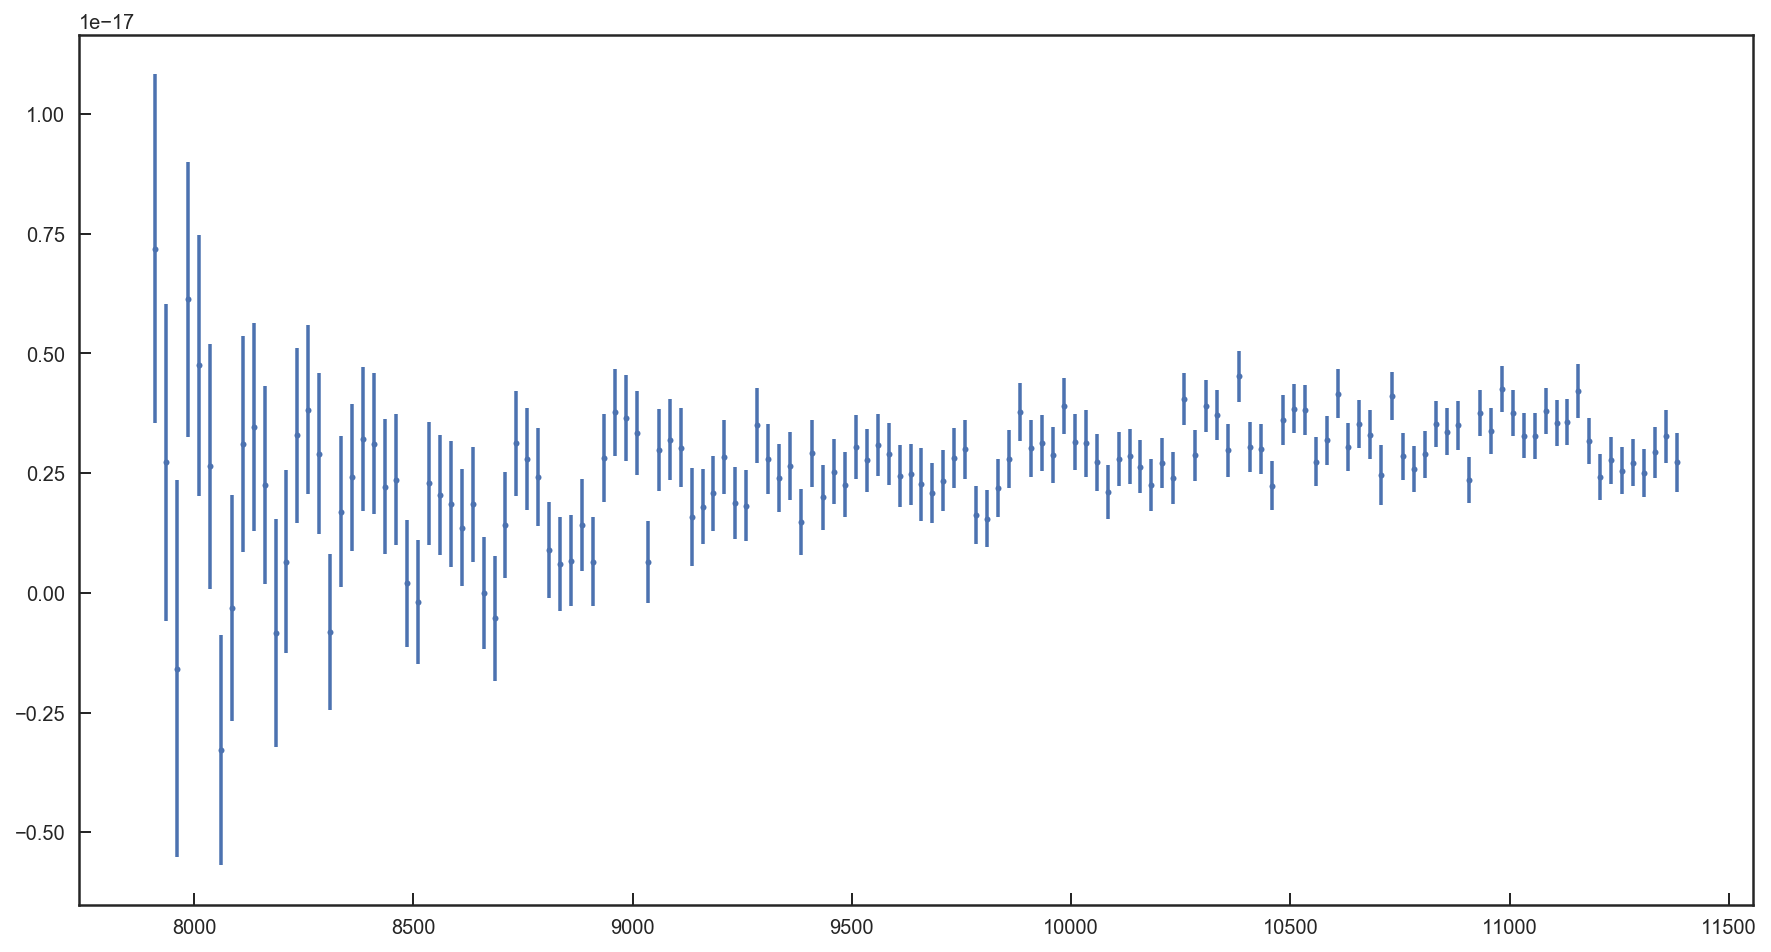

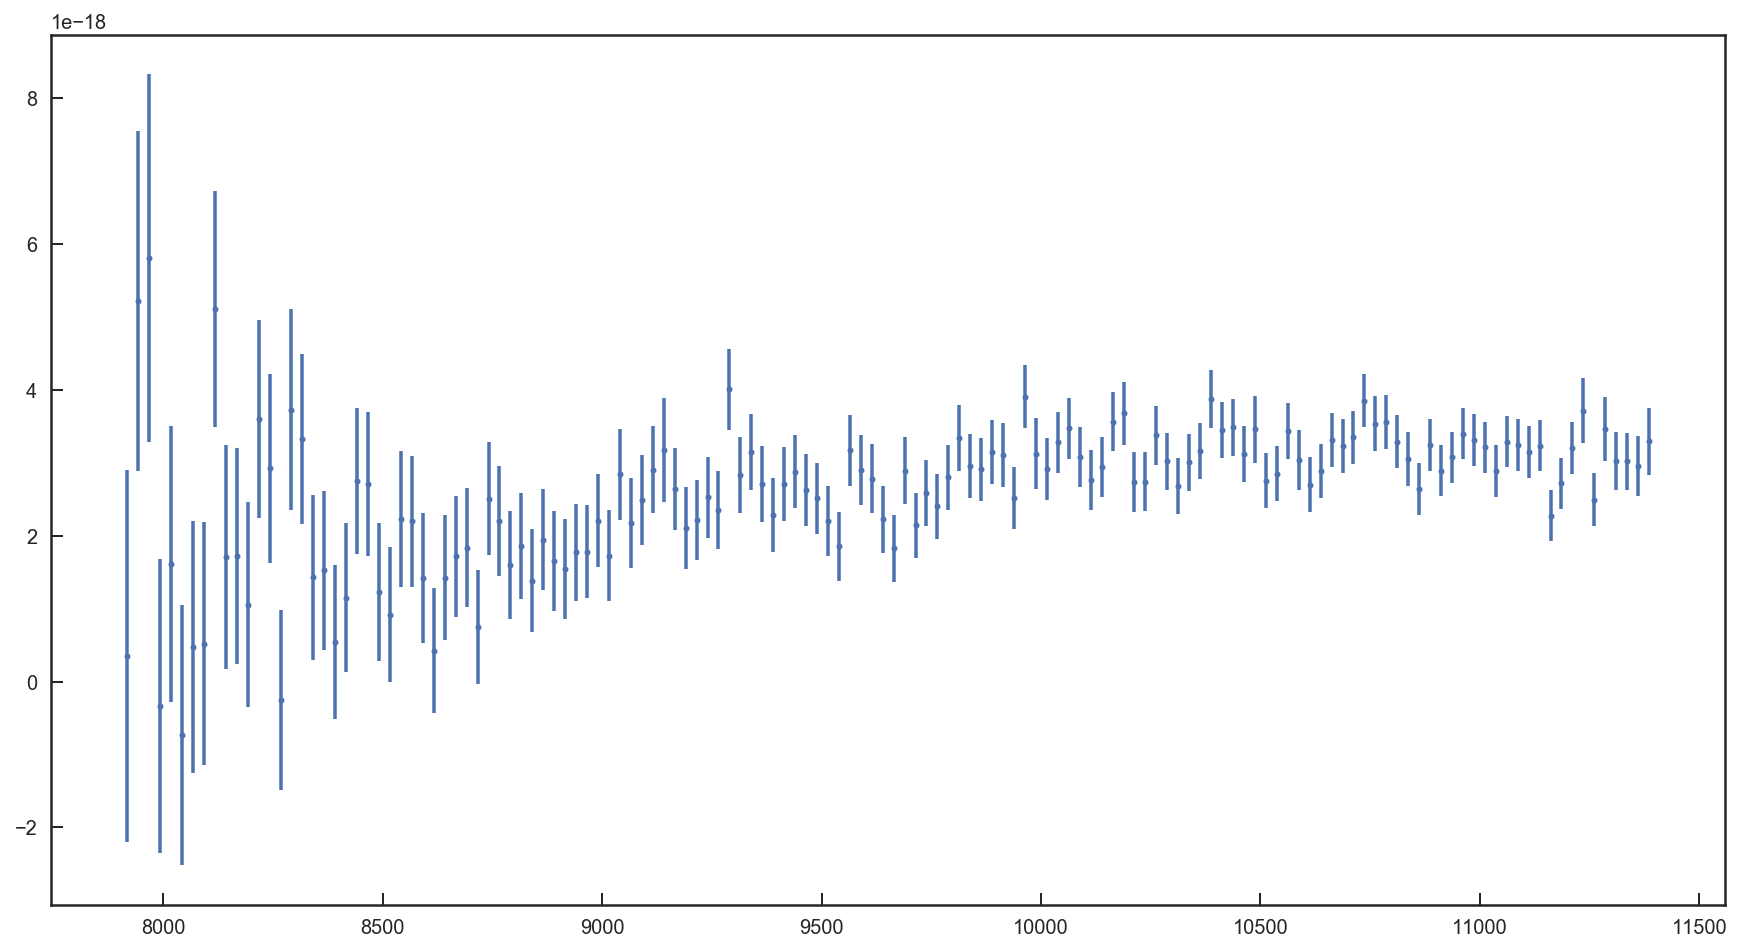

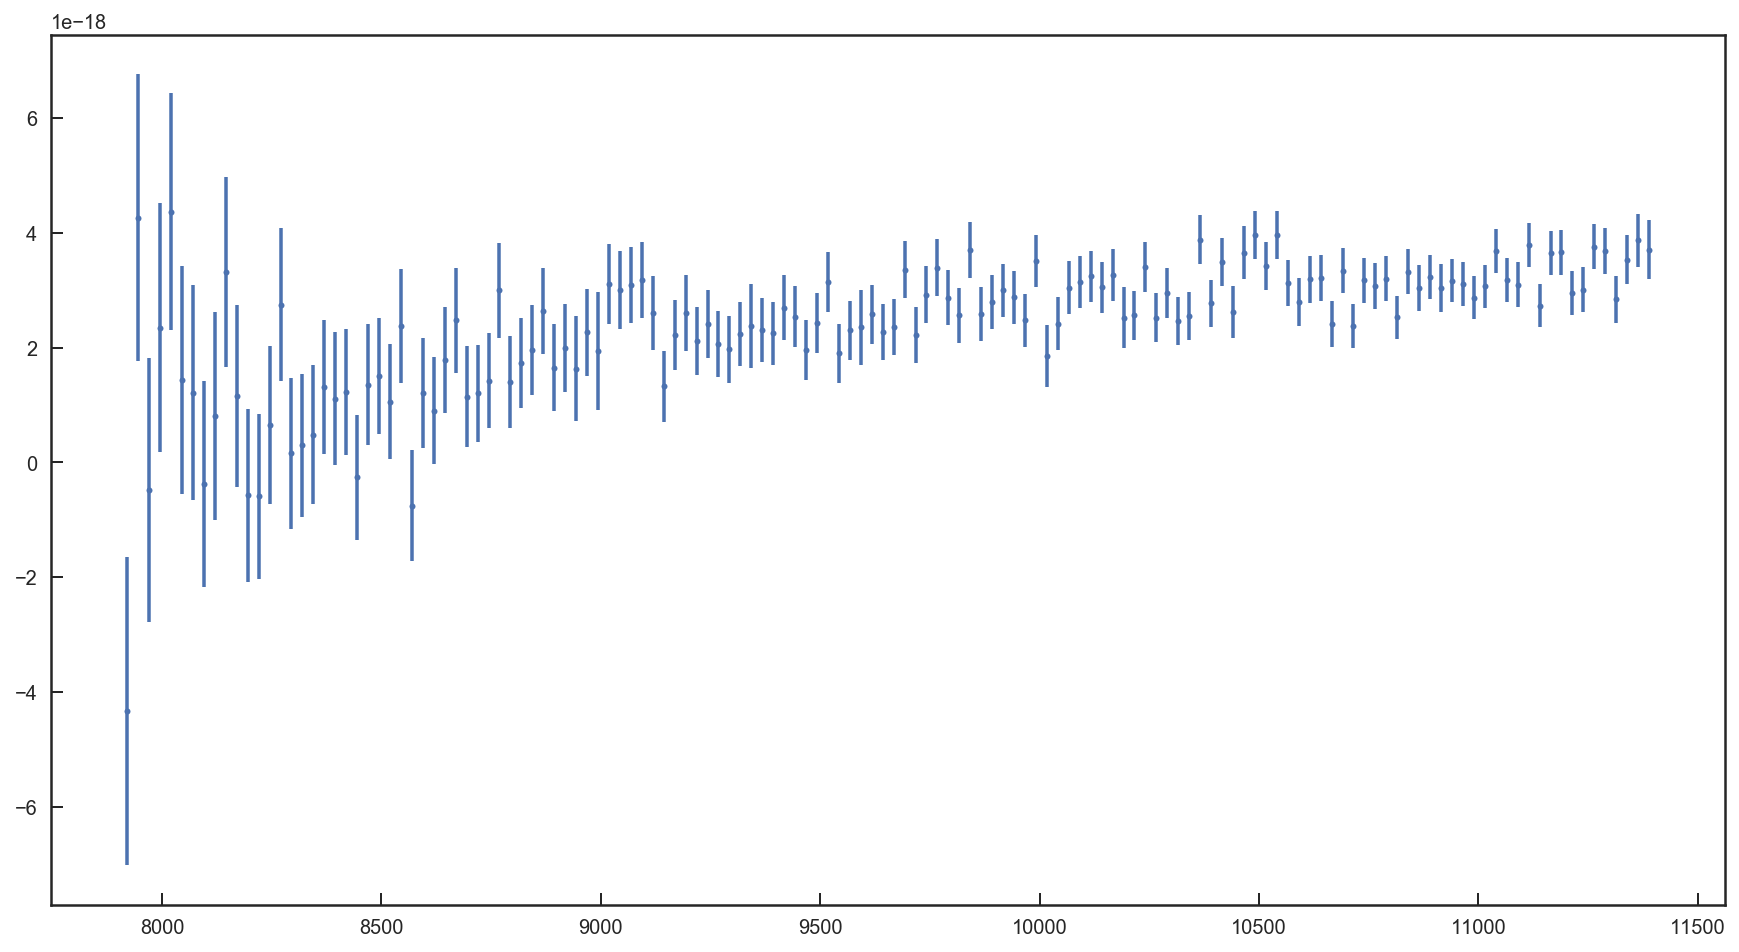

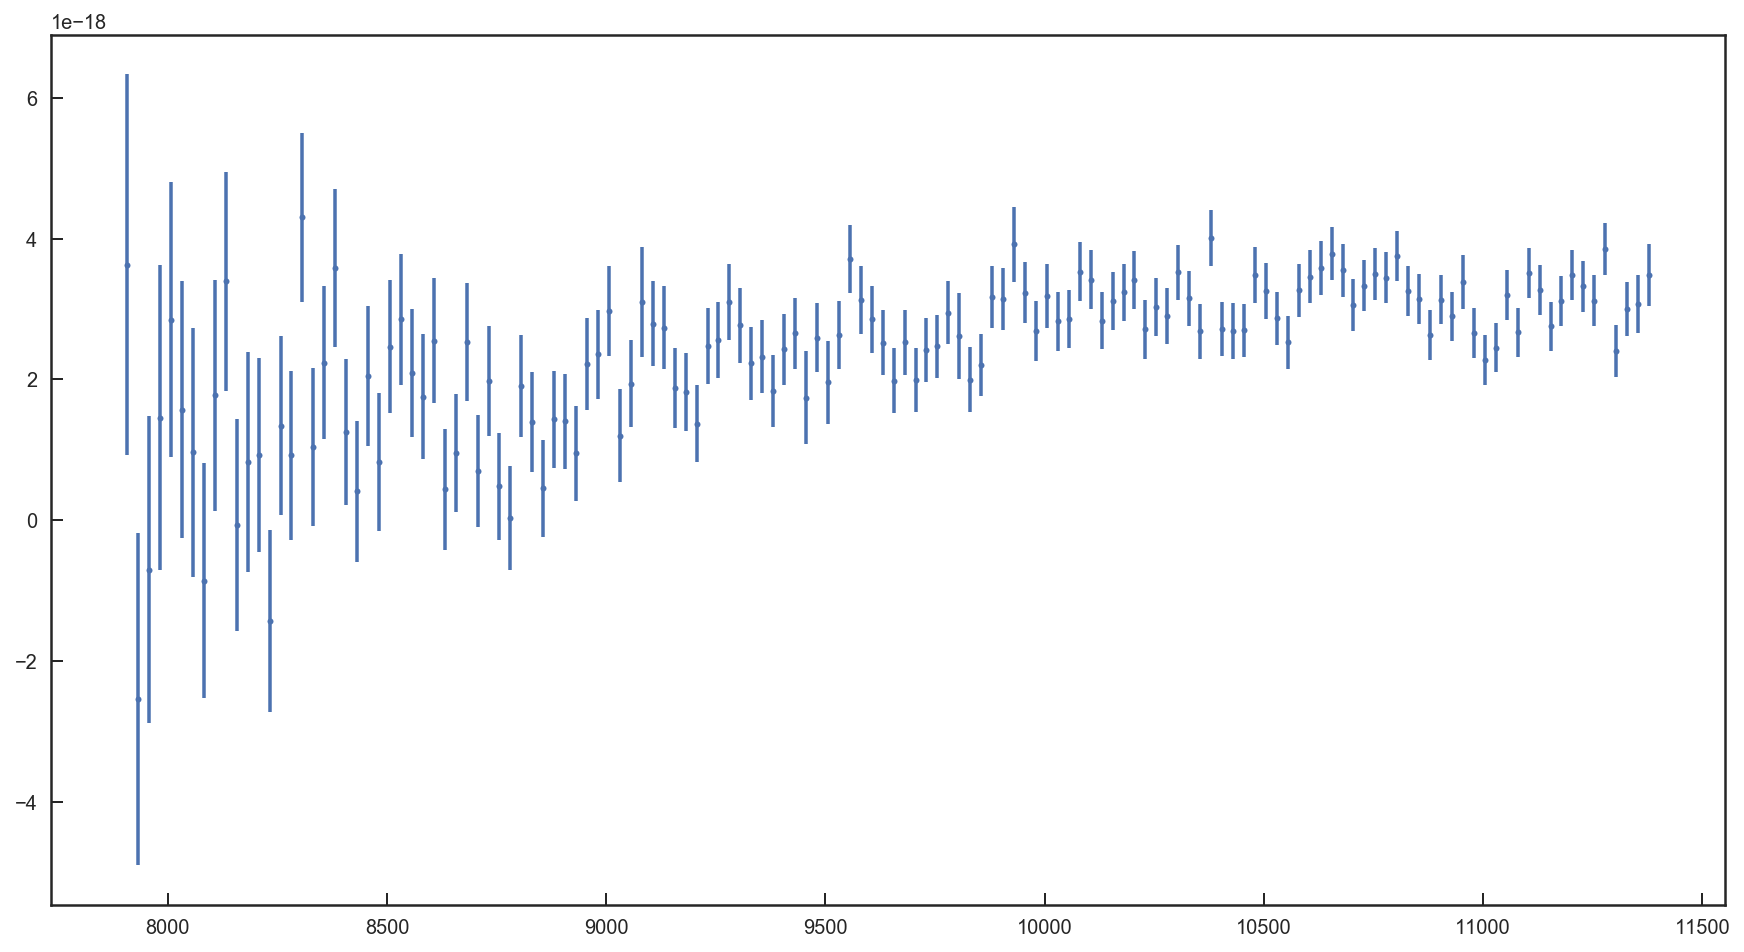

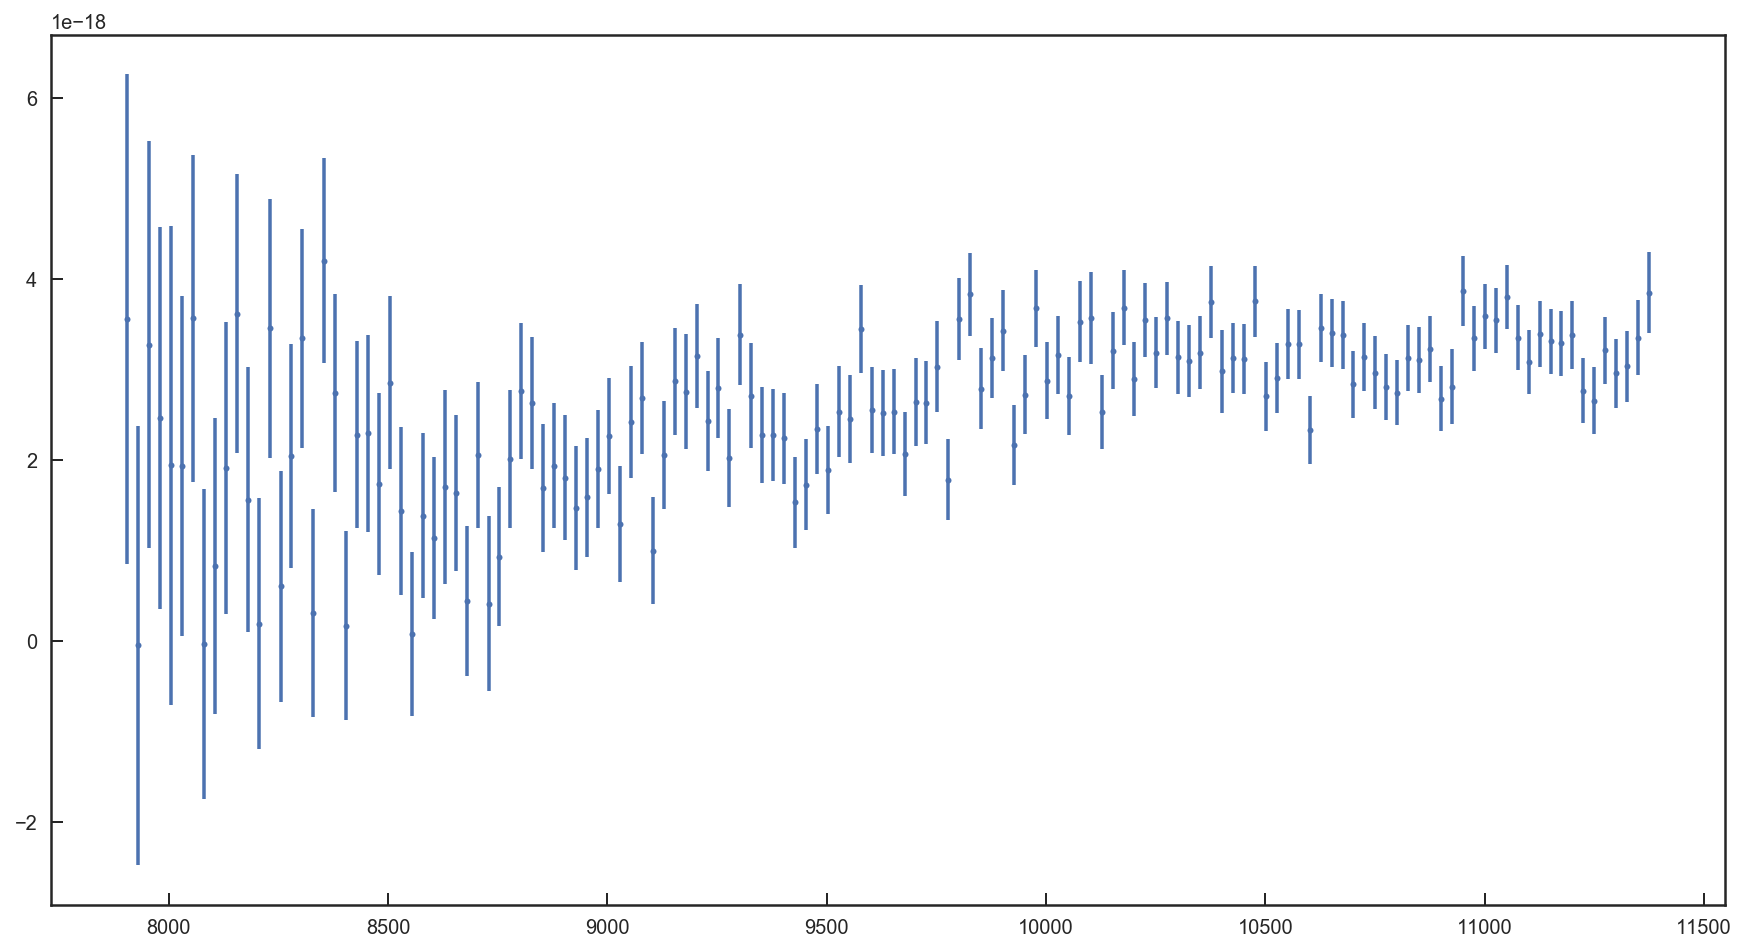

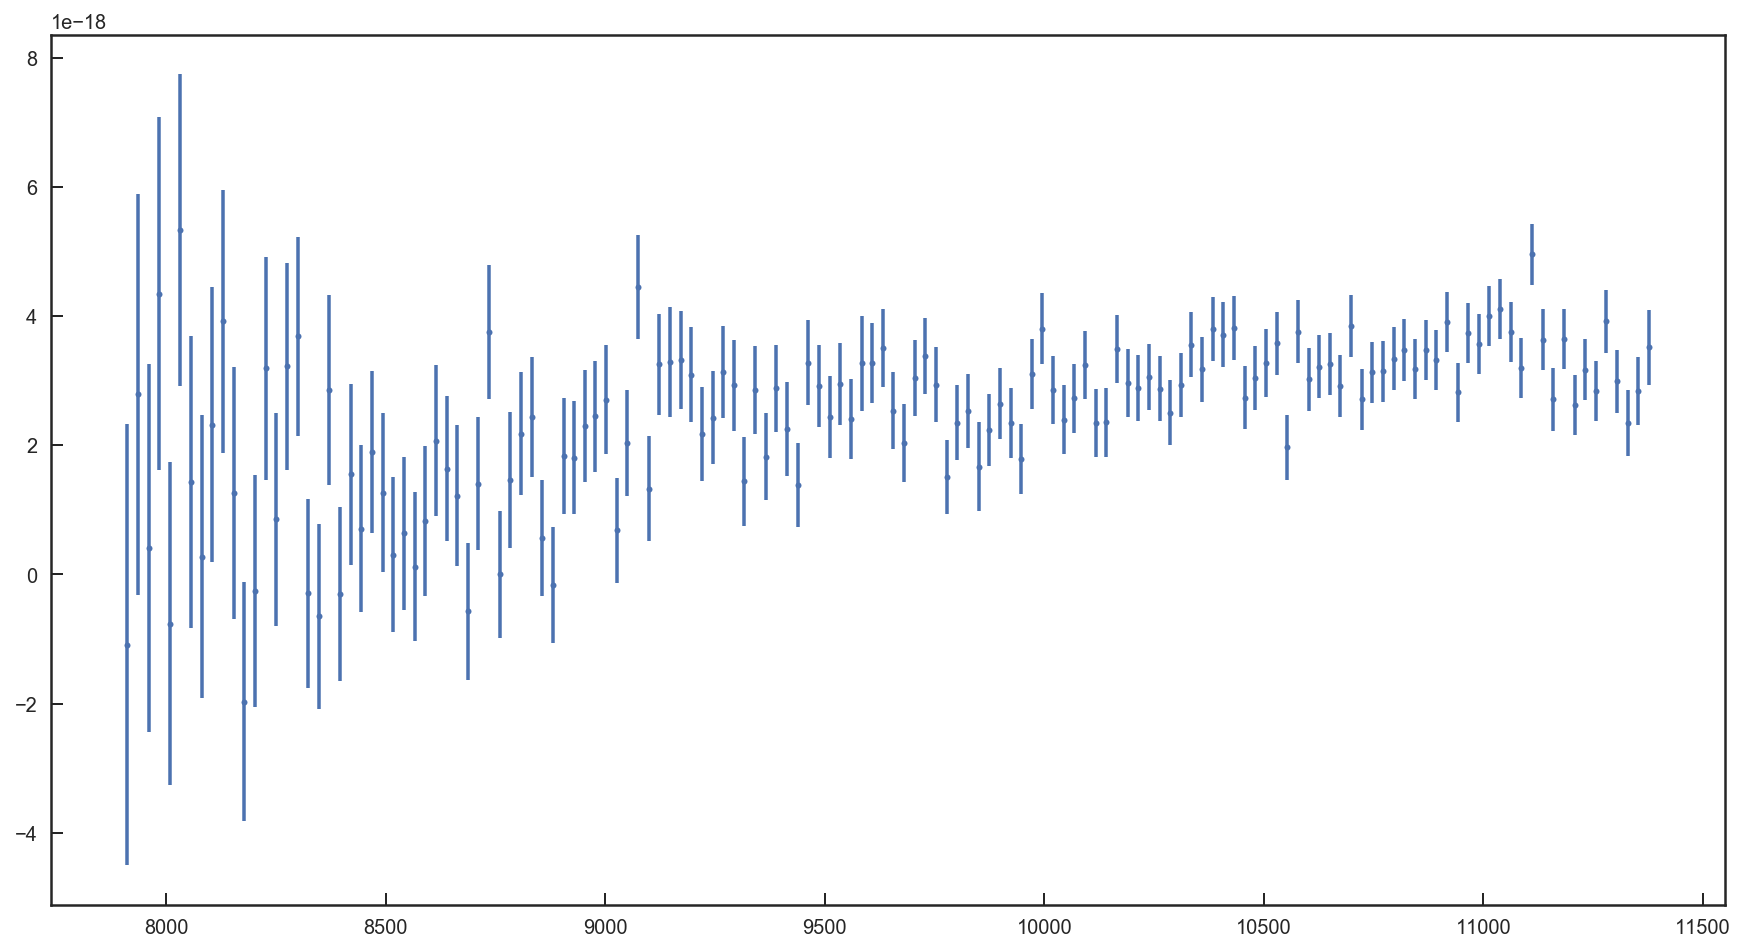

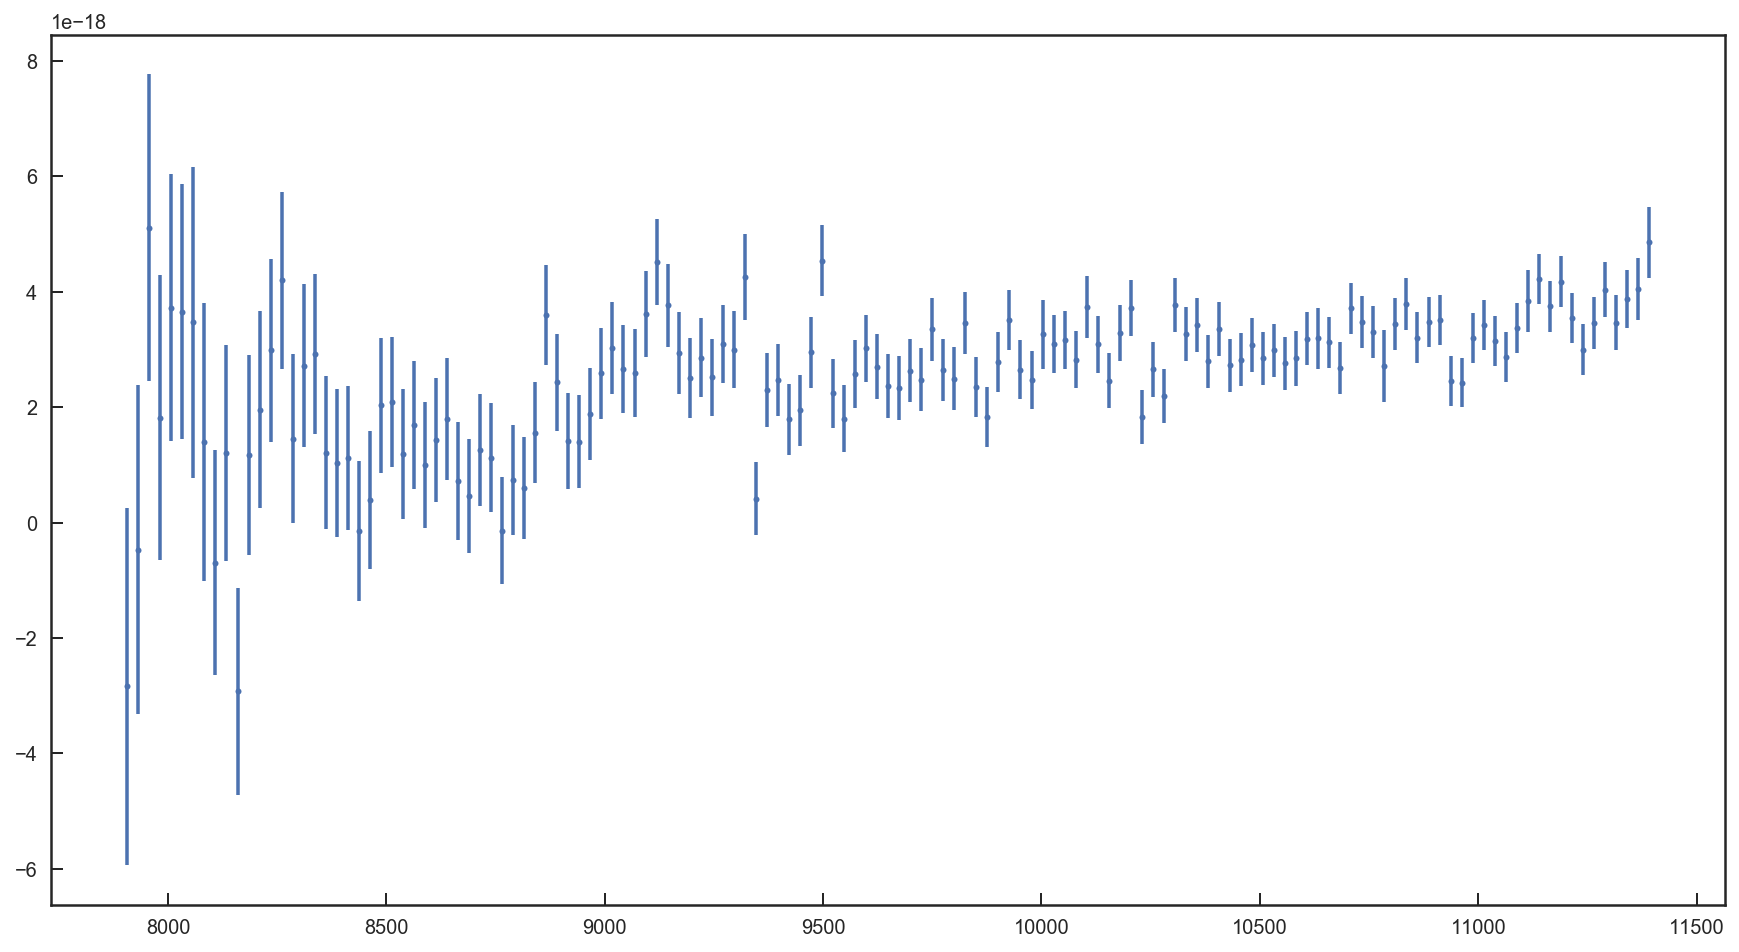

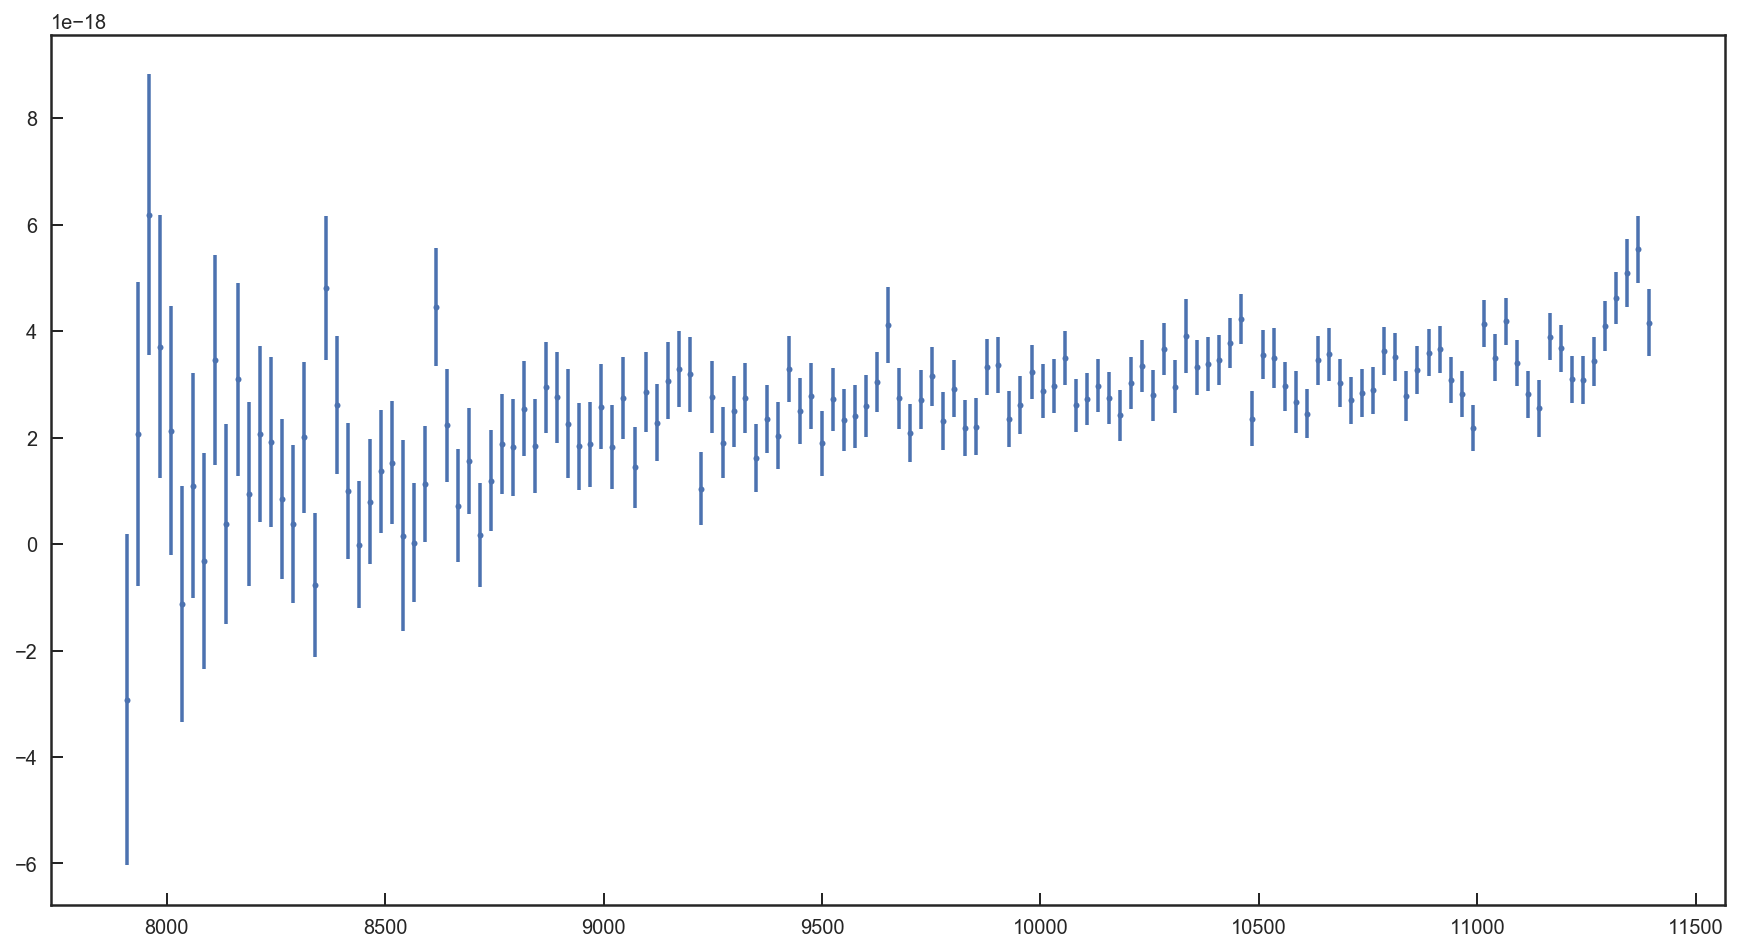

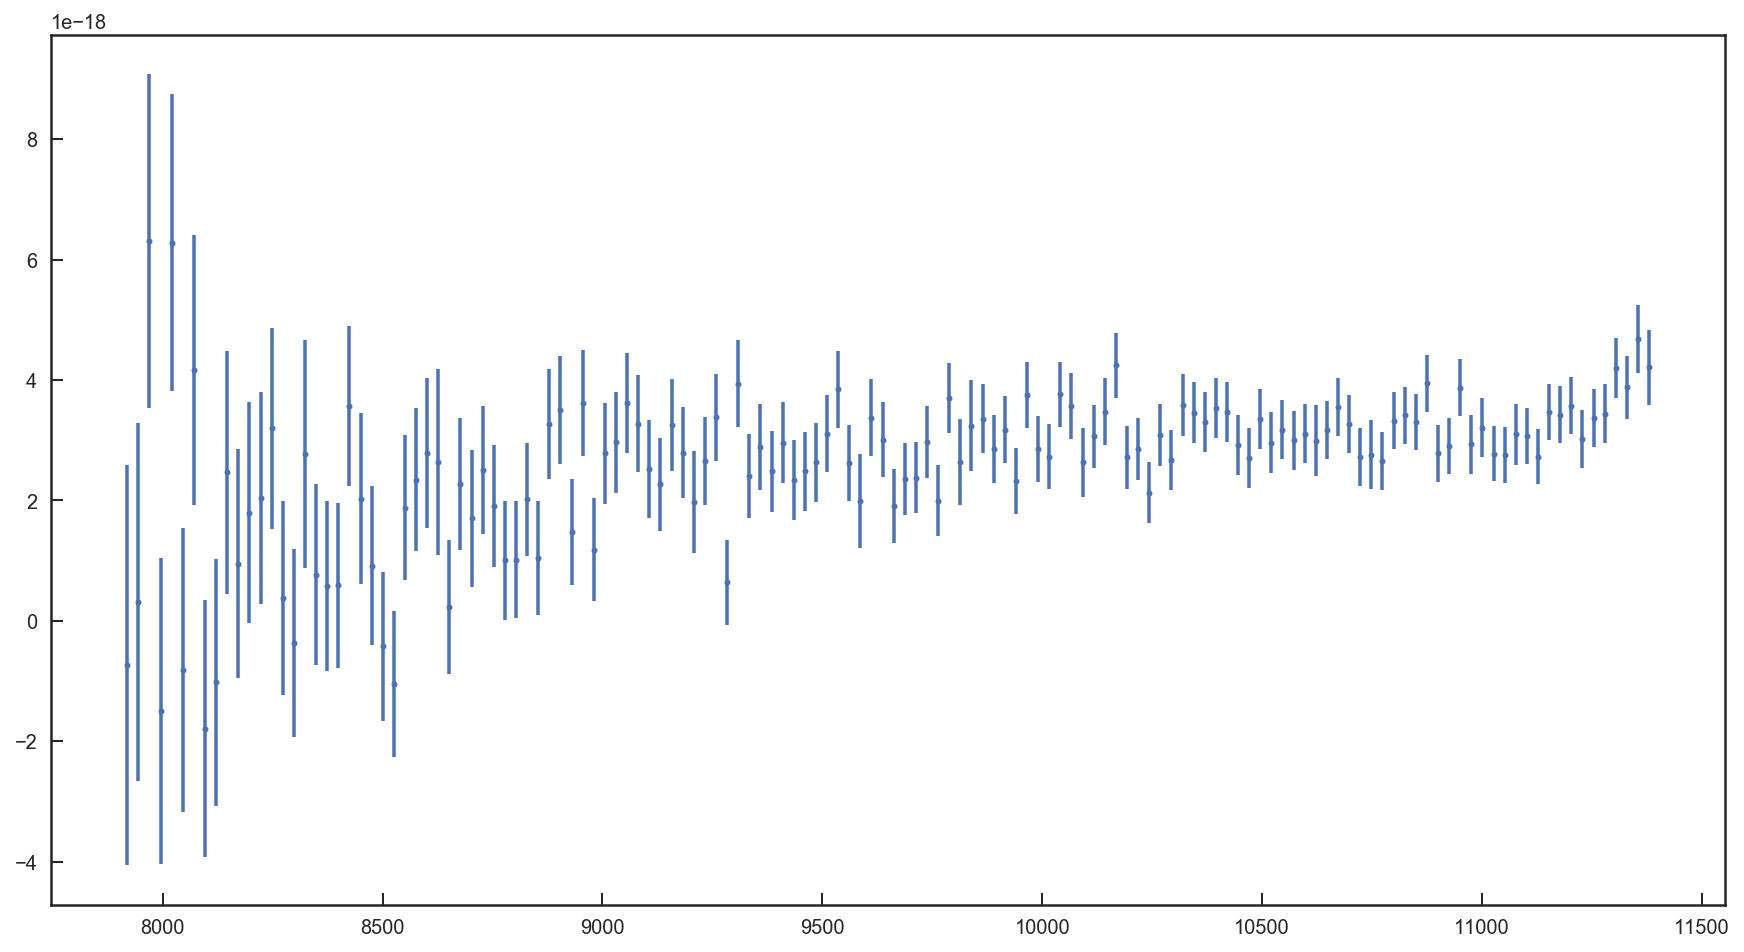

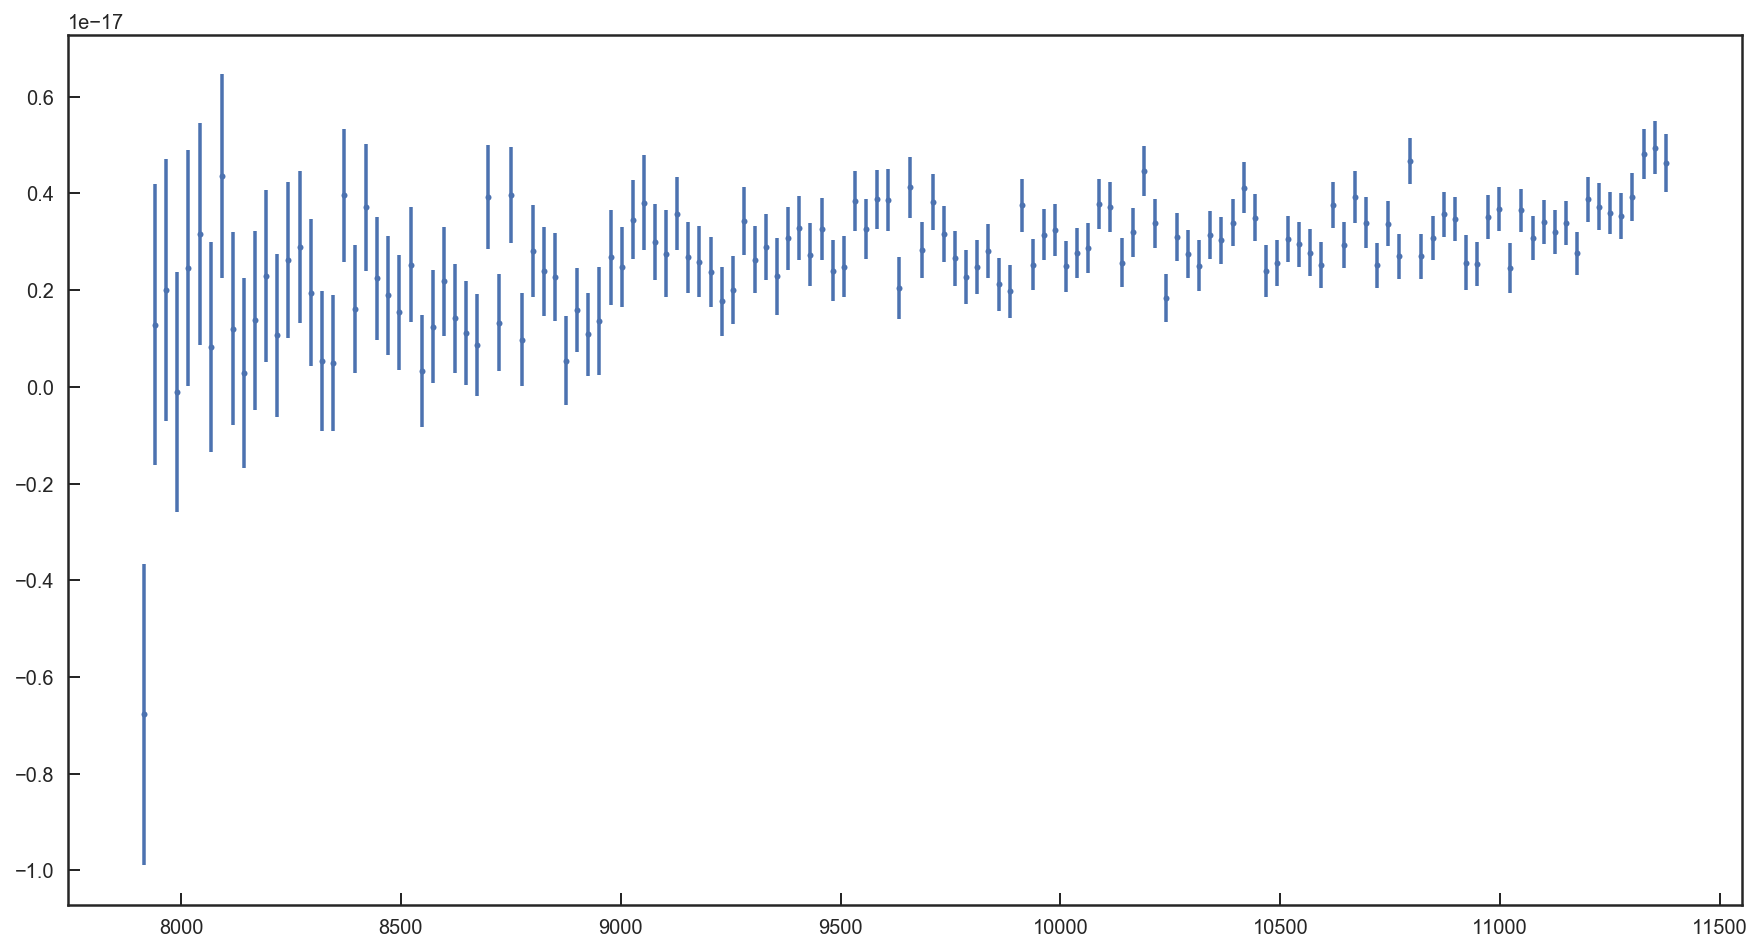

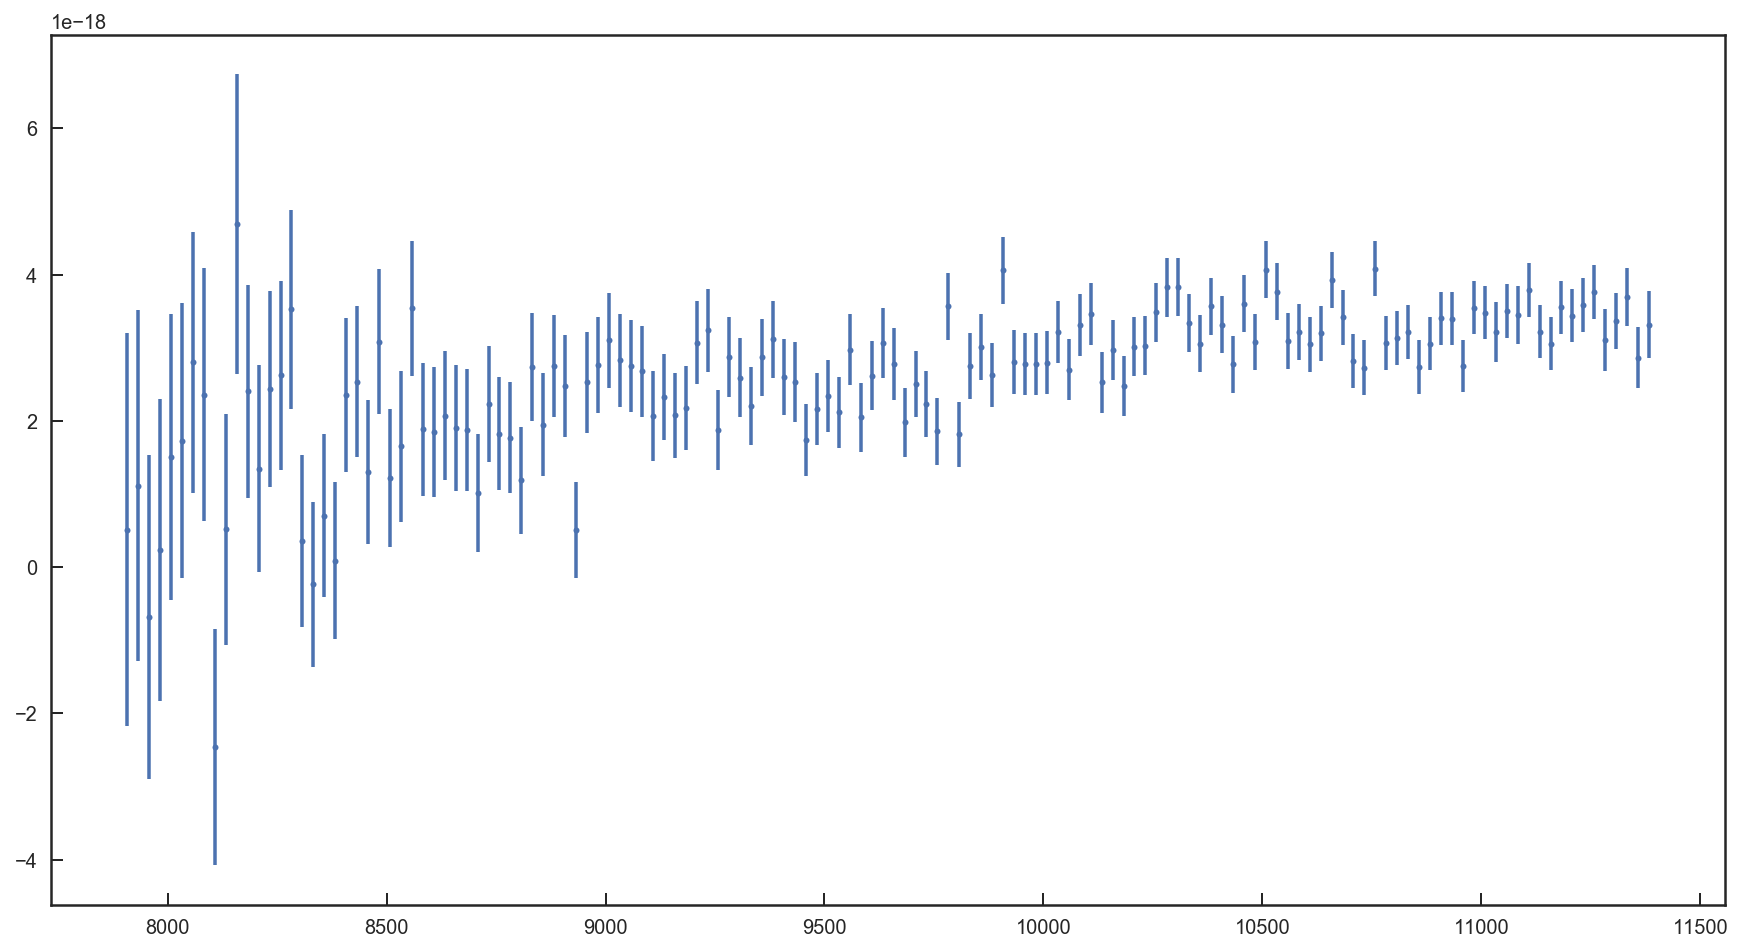

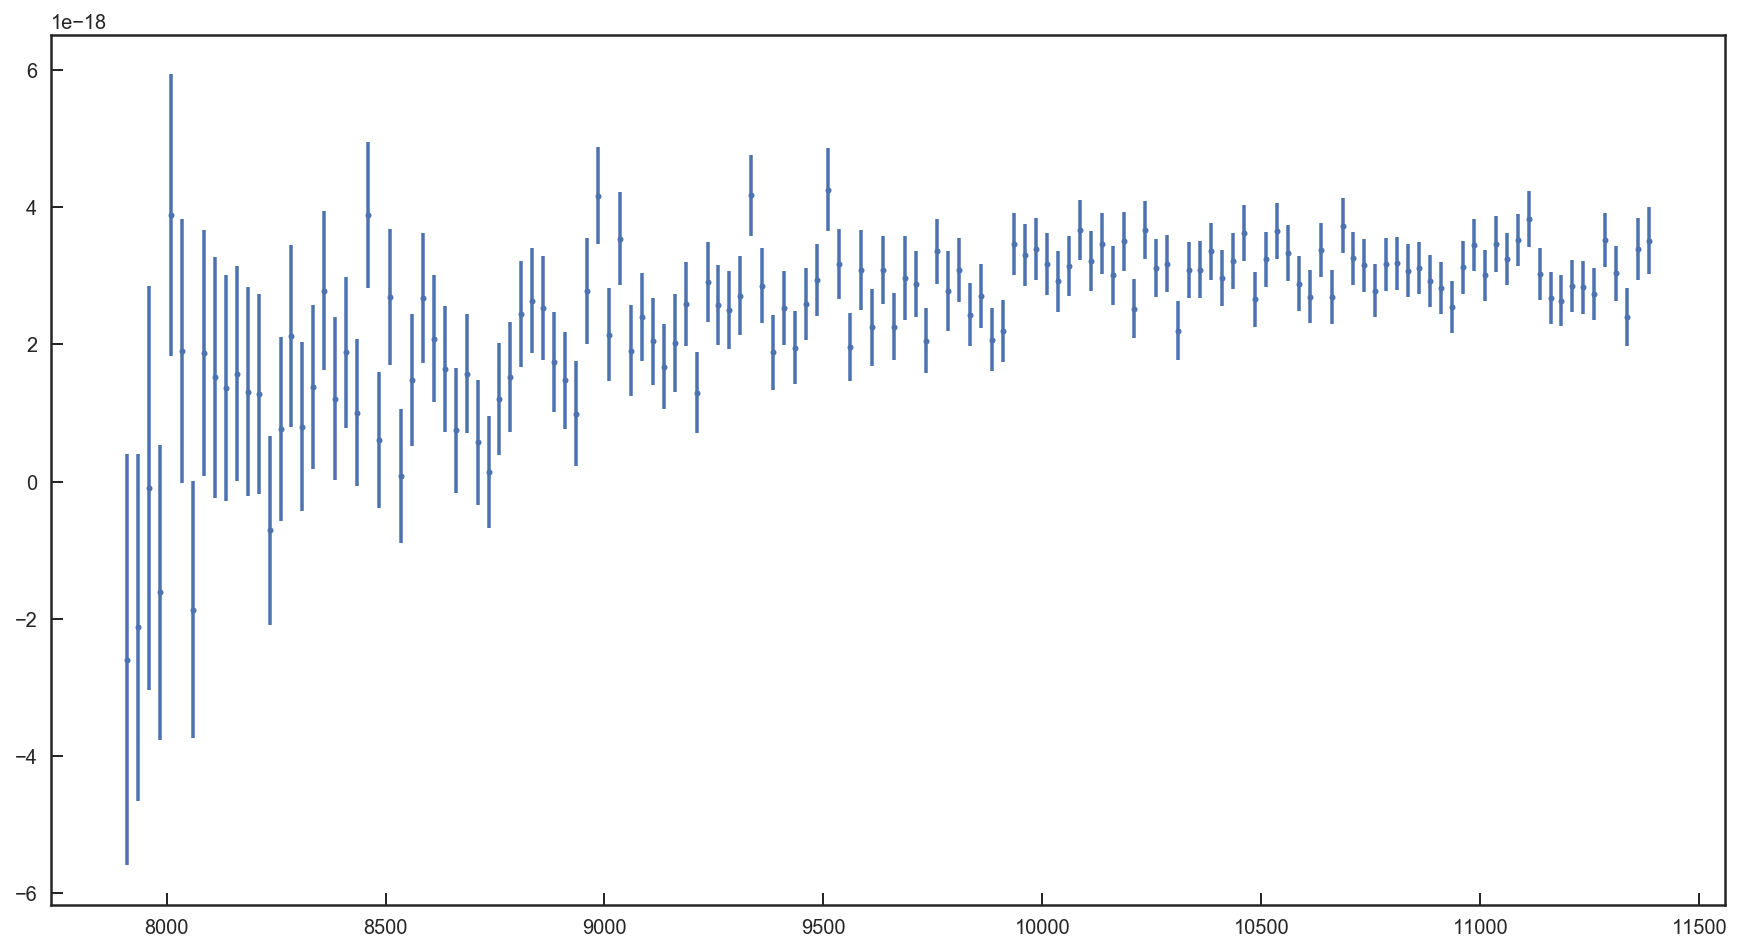

In [9]:
specs = glob('specs/*')
for i in specs:
    wv,fl,er = np.load(i)
    IDX = [U for U in range(len(wv)) if 7900 < wv[U] < 11400]
    plt.figure(figsize=[15,8])
    plt.errorbar(wv[IDX],fl[IDX],er[IDX],linestyle='None', marker='o', markersize=3)

In [24]:
 wv,fl,er = np.load(specs[0])
# stack_wv = wv[3:-3]
stack_wv = np.arange(7500,11800, wv[1] - wv[0])

flgrid = np.zeros([len(specs), len(stack_wv)])
errgrid = np.zeros([len(specs), len(stack_wv)])

# Get wv,fl,er for each spectra
for i in range(len(specs)):
    wv,fl,er = np.load(specs[i])
    wv = wv[fl**2 > 0]
    er = er[fl**2 > 0]
    fl = fl[fl**2 > 0]
    
    flgrid[i] = interp1d(wv, fl)(stack_wv)
    errgrid[i] = interp1d(wv, er)(stack_wv)

################

flgrid = np.transpose(flgrid)
errgrid = np.transpose(errgrid)
weigrid = errgrid ** (-2)
infmask = np.isinf(weigrid)
weigrid[infmask] = 0
################

stack, err = np.zeros([2, len(stack_wv)])
for i in range(len(stack_wv)):
    stack[i] = np.sum(flgrid[i] * weigrid[[i]]) / (np.sum(weigrid[i]))
    err[i] = 1 / np.sqrt(np.sum(weigrid[i]))
################


stack_fl = np.array(stack)
stack_er = np.array(err)

(0, 5e-18)

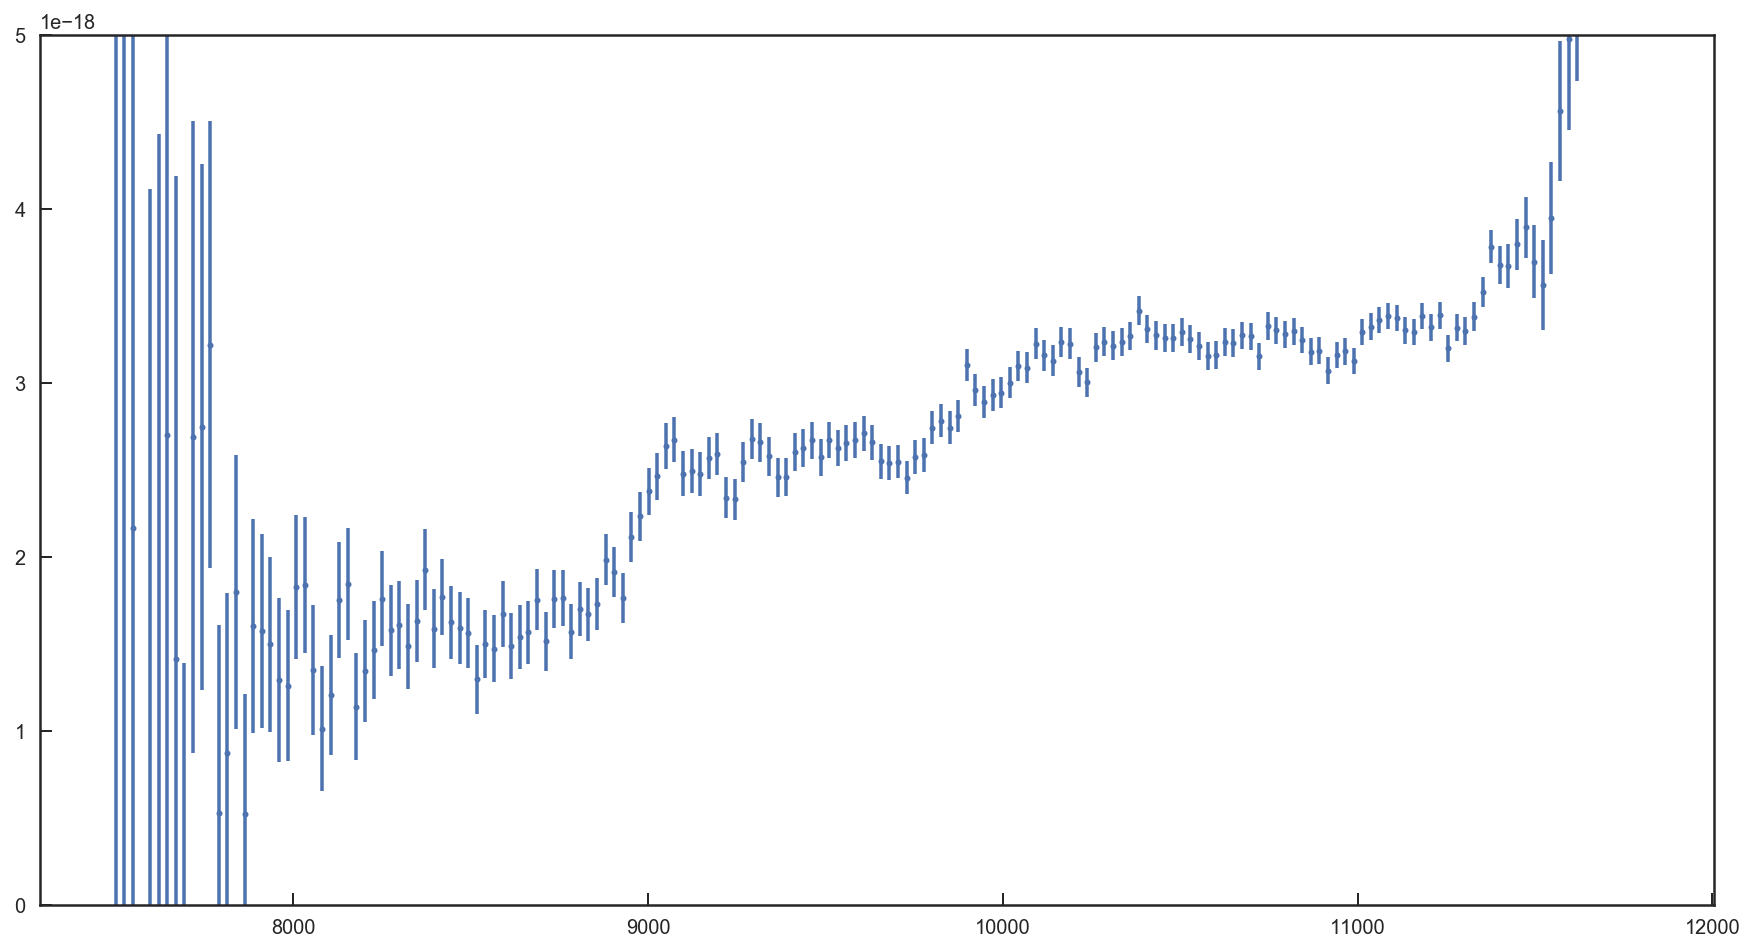

In [26]:
plt.figure(figsize=[15,8])
plt.errorbar(stack_wv,stack_fl,stack_er,linestyle='None', marker='o', markersize=3)
plt.ylim(0,5E-18)

In [23]:
np.arange(7500,11800, wv[1] - wv[0])

array([ 7500.        ,  7525.00267479,  7550.00534958,  7575.00802437,
        7600.01069916,  7625.01337395,  7650.01604874,  7675.01872353,
        7700.02139831,  7725.0240731 ,  7750.02674789,  7775.02942268,
        7800.03209747,  7825.03477226,  7850.03744705,  7875.04012184,
        7900.04279663,  7925.04547142,  7950.04814621,  7975.050821  ,
        8000.05349579,  8025.05617058,  8050.05884536,  8075.06152015,
        8100.06419494,  8125.06686973,  8150.06954452,  8175.07221931,
        8200.0748941 ,  8225.07756889,  8250.08024368,  8275.08291847,
        8300.08559326,  8325.08826805,  8350.09094284,  8375.09361763,
        8400.09629242,  8425.0989672 ,  8450.10164199,  8475.10431678,
        8500.10699157,  8525.10966636,  8550.11234115,  8575.11501594,
        8600.11769073,  8625.12036552,  8650.12304031,  8675.1257151 ,
        8700.12838989,  8725.13106468,  8750.13373947,  8775.13641426,
        8800.13908904,  8825.14176383,  8850.14443862,  8875.14711341,
      